In [854]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import time, date, datetime
import os
from ldap3 import Server, Connection, SIMPLE, SYNC, ALL
#from pyad import *
import pyodbc
import os
import re
from unidecode import unidecode
from datetime import datetime
from unidecode import unidecode
%matplotlib inline
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
#Timestap para validar inicio del notebook
comienzonotebook = datetime.now()

In [861]:
# Creacion de la conexión a la base de datos ITSM Aranda
connAranda = pyodbc.connect(driver="{SQL Server}",server='172.16.20.90',database='ArandaDB8',uid='arandauser',pwd='XXXXXXX3')
#connAranda = pyodbc.connect("DSN=ArandaDSN")

# Creacion de la conexión a la base de datos ITSM DiscoveryHawk
connDiscov = pyodbc.connect(driver="{SQL Server}",server='172.16.20.70',database='DiscovSQL',uid='discoveryuser',pwd='XXXXXX2024')
#connDiscov = pyodbc.connect("DSN=DiscovDSN")


In [862]:
#conexion con la BD de Kactus de empleados
#connKactus = pyodbc.connect("DSN=KactusDSN")
connKactus = pyodbc.connect(driver="{SQL Server}",server='172.16.20.70',database='kactus',uid='discoveryuser',pwd='XXXXXX2024')

#query de lectura para generar tabla maestra de usuarios y con nombre completo, cedula y correo
queryKactus = "select distinct  RTRIM(emp.nom_empl) + ' ' + RTRIM(emp.ape_empl) as NombreCompleto, cast(emp.cod_empl as varchar(50)) as cedula, case when CHARINDEX('@', emp.box_mail) > 0 then left(emp.box_mail, CHARINDEX('@', emp.box_mail) -1 ) else emp.box_mail end as username  from gn_accaj gn  inner join bi_emple emp on gn.COD_EMPL = emp.cod_empl  where CHARINDEX('@', emp.box_mail) > 0  order by NombreCompleto "

#leyendo la consulta de SQL y creando un dataframe maestro de 
kactus = pd.read_sql(queryKactus, connKactus)

C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\4038889648.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  kactus = pd.read_sql(queryKactus, connKactus)


In [5]:
#visualizacion de este dataframe que cuenta como columna maestra
kactus.head()

,NombreCompleto,cedula,username
0,ADALBERTO CHARRIS MEJIA,72314652,acharris
1,ADOLFO CACERES MELO,79691436,acaceres
2,ADRIAN IVANOV CORREA MORENO,91176740,acorrea
3,ADRIANA CRISTINA PINZON NIÑO,46450472,apinzon
4,ADRIANA MERCEDES AMADOR DE VIVERO,1018430921,aamador


In [6]:
#Conversión de los query en los dataframes de las herramientas ITSM Discovery y Aranda
#Definicion de los query SQL para ejecutar los procedimientos almacenados que se habían creado previamente
sp_discovery = "exec SP_CASOS_DISCOVERYGTI_V1"
#leyendo la consulta de SQL y convirtiendolas en dataframes
discovery = pd.read_sql(sp_discovery, connDiscov)

C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\3907531157.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  discovery = pd.read_sql(sp_discovery, connDiscov)


In [7]:
#definicion de los query y lectura de los datos SQL con la ejecución de los SP
#conversión del resultado a dataframe
sp_cambAranda = "exec SP_CHANGES"
sp_reqAranda = "exec SP_SERVICECALL"
sp_incAranda = "exec SP_INCIDENTESGTI"

arandaInci = pd.read_sql(sp_incAranda, connAranda)
arandaReq = pd.read_sql(sp_reqAranda, connAranda)
arandaDes = pd.read_sql(sp_cambAranda, connAranda)

C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\2222913784.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  arandaInci = pd.read_sql(sp_incAranda, connAranda)
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\2222913784.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  arandaReq = pd.read_sql(sp_reqAranda, connAranda)
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\2222913784.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  arandaDes = pd.read_sql(sp_cambAranda, connAranda)


In [8]:
#Copia del dataframe para no trabajar con el original
discovery1 = discovery.copy()

In [9]:
#ciclo para  guardar los números de cédula que estan en lugar del usuario de AD, para su validacion
listacedulas = []
for i, fila, in discovery.iterrows():
    if str(fila['username_ufinal']).isdigit():
        listacedulas.append(discovery.loc[i , 'username_ufinal'])


In [10]:
#Conexión a LDAP AD y pruebas
server_address = 'ldap://172.16.0.5:389'  # Conexión al servidor de LDAP AD
base_dn = 'dc=FINAGRO,dc=LOC'  # Base domain name
#ou = 'ou=FINAGRO'  # Unidad organizativa
username = 'FINAGRO\entrustuser'
password = 'XXXXXXXX!/'

# Crea el objeto Server
server = Server(server_address)
def convertirCedula(cedula):
    username1 = ''
    try:
        # Intenta conectarte al servidor LDAP
        with Connection(server, user=username, password=password, authentication=SIMPLE, raise_exceptions=True) as conn:
            # Bind al servidor LDAP
            conn.bind()
            # Realiza una búsqueda por el ID del empleado
            search_filter = f'(&(objectClass=user)(employeeID={cedula}))' #busqueda del colaborador por su cedula
            conn.search(search_base=base_dn,
                        search_filter=search_filter,
                        search_scope='SUBTREE',
                        attributes=['sAMAccountName'])
            
            # Imprime los resultados de la búsqueda
            for entry in conn.entries:
               username1 = entry.sAMAccountName.value if 'sAMAccountName' in entry else 'N/A'
               print(f'ID de Empleado: {cedula} - encontrado el: {username1}')
           # entry = conn.entries.first()
           
    except Exception as e:
        print(f'Error: {e}')
    return username1

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\2337078097.py:7: SyntaxWarning: invalid escape sequence '\e'
  username = 'FINAGRO\entrustuser'


In [11]:
#exploración de los datos a nivel dataframe
discovery.head(6)

,tipo_de_caso,origen_caso,proyecto,numero_caso,servicio,responsable,username_resp,usuariofinal,username_ufinal,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido,CUMPLE_ANS
0,REQUERIMIENTO,Discovery,Soporte,56060,APLICATIVO BUZON SEGURO,CAROLINE PAEZ CHINONES,CPAEZ,SANDRA PATRICIA CASTILLO RAMIREZ,SCASTILLO,2024-04-22 15:31:15,2024-05-02 11:58:25,2024-05-02 11:58:46,3574,SI
1,INCIDENTE,Discovery,Soporte,56057,APLICATIVOS MICROSOFT OFFICE (EXCEL - ACCESS -...,JESUS MARTIN QUINTERO,MQUINTERO,None,1016019641,2024-03-20 15:47:39,2024-03-21 10:04:03,2024-03-21 11:51:09,75,SI
2,INCIDENTE,Discovery,Soporte,56055,APLICATIVO SARLAFT,YENNIFER ALEJANDRA VARGAS ZABALA,YAVARGAS,GUILLERMO GUTIERREZ CRUZ,GGUTIERREZ,2024-03-20 07:50:04,2024-03-20 08:22:48,2024-03-20 08:56:38,56,SI
3,INCIDENTE,Discovery,Soporte,56054,APLICATIVO SARLAFT,YENNIFER ALEJANDRA VARGAS ZABALA,YAVARGAS,GUILLERMO GUTIERREZ CRUZ,GGUTIERREZ,2024-03-18 14:05:53,2024-03-19 15:20:27,2024-03-20 07:34:45,717,SI
4,INCIDENTE,Discovery,Soporte,56053,APLICATIVO SARLAFT,YENNIFER ALEJANDRA VARGAS ZABALA,YAVARGAS,GUILLERMO GUTIERREZ CRUZ,GGUTIERREZ,2024-03-18 14:05:49,2024-03-19 15:11:22,2024-03-20 07:34:12,717,SI
5,REQUERIMIENTO,Discovery,Soporte,56052,APLICATIVO BUZON SEGURO,JESUS MARTIN QUINTERO,MQUINTERO,SANDRA PATRICIA CASTILLO RAMIREZ,SCASTILLO,2024-03-13 14:30:40,2024-03-21 07:08:00,2024-03-21 07:26:38,2856,SI


In [12]:
listacedulas1 = []
for i, fila, in discovery.iterrows():
    if str(fila['username_ufinal']).isdigit():
        listacedulas1.append(discovery.loc[i , 'username_ufinal'])

In [13]:
#Impresion de la cantidad de filas que contienen cedulas
print(listacedulas1[0])
len(listacedulas1)

1016019641


841

In [14]:
#revision de dataframe kactus que servirá para llenar datos de los empleados del dataframe Discovery
kactus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   NombreCompleto  706 non-null    object
 1   cedula          706 non-null    object
 2   username        706 non-null    object
dtypes: object(3)
memory usage: 16.7+ KB


In [15]:
#Ciclo para llenar los nombres de usuario restantes cuando el campo contiene la cedula en lugar del username, valores inconsistentes
#valiendose del dataframe Kactus el cual contiene los usernames reales por cédula
print(datetime.now())
for i, fila, in discovery1.iterrows():
    
    
    if discovery1.loc[i , 'username_ufinal'].isdigit():
       # print(f"{discovery1.loc[i , 'username_ufinal']} tiene cedula en lugar de username; se convierte")
        for j, fila, in kactus.iterrows():
            if kactus.loc[j,'cedula'] == discovery1.loc[i , 'username_ufinal']:
                valor = kactus.loc[j, 'username']
                valorNombre = kactus.loc[j, 'NombreCompleto']
                discovery1.loc[i , 'username_ufinal'] = valor              
                discovery1.loc[i , 'usuariofinal'] = valorNombre

    elif discovery1.loc[i , 'username_ufinal'] == '172.16.9.85':
        #corrección de una data específica inconsistente donde el sistema tomó la IP del equipo en lugar del username
        #print('Corregida inconsistencia 172.16.9.85 a verdadero nombre de usuario masmar')
        discovery1.loc[i , 'username_ufinal'] = 'masmar'
    
    elif pd.isna(discovery1.loc[i , 'responsable']):
        #print(f"{discovery1.loc[i , 'username_resp']} responsable vacio; se convierte")
        for j, fila, in kactus.iterrows():
            if kactus.loc[j,'username'].lower() == discovery1.loc[i , 'username_resp'].lower():
                valorNombre = kactus.loc[j, 'NombreCompleto']
                discovery1.loc[i , 'responsable'] = valorNombre
                            
print(datetime.now())

2024-05-29 10:00:09.172065
2024-05-29 10:00:57.817363


In [16]:
#exploracion df 
discovery1.tail(2)

,tipo_de_caso,origen_caso,proyecto,numero_caso,servicio,responsable,username_resp,usuariofinal,username_ufinal,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido,CUMPLE_ANS
26311,INCIDENTE,Discovery,Soporte,5,APLICATIVO CARTERAS SFI,JESUS MARTIN QUINTERO,MQUINTERO,JESUS MARTIN QUINTERO,MQUINTERO,2014-12-05 20:15:42,2014-12-05,2014-12-05 20:45:36,0,SI
26312,INCIDENTE,Discovery,Soporte,4,APLICATIVO CARTERAS SFI,JESUS MARTIN QUINTERO,MQUINTERO,JESUS MARTIN QUINTERO,MQUINTERO,2014-12-05 20:08:11,2014-12-05,2014-12-05 20:46:36,0,SI


In [17]:
#CICLO CON LDAP AD FINAGRO.LOC
#Ciclo para llenar los valores de username a traves de los numeros de cedula y LDAP que quedaron en la columna username_ufinal
#pues no todos se pudieron procesar a traves de la consulta de base de datos de nomina (kactus)
print(datetime.now())
for i, fila, in discovery.iterrows():
    if discovery1.loc[i , 'username_ufinal'].isdigit():
        #print(discovery1.loc[i, 'username_ufinal'],"es digito y se agrega en el campo")
        #enviar las consultas con un argumento a la funcion de LDAP
        discovery1.loc[i, 'username_ufinal'] = convertirCedula(discovery1.loc[i, 'username_ufinal'])
        
        
    

print(datetime.now())

2024-05-29 10:00:57.858208
1030547774 es digito y se agrega en el campo
ID de Empleado: 1030547774 - encontrado el: xvargas
314 es digito y se agrega en el campo
1075262699 es digito y se agrega en el campo
ID de Empleado: 1075262699 - encontrado el: raordonez
1136911310 es digito y se agrega en el campo
ID de Empleado: 1136911310 - encontrado el: fbecker
1136911310 es digito y se agrega en el campo
ID de Empleado: 1136911310 - encontrado el: fbecker
1136911310 es digito y se agrega en el campo
ID de Empleado: 1136911310 - encontrado el: fbecker
1136911310 es digito y se agrega en el campo
ID de Empleado: 1136911310 - encontrado el: fbecker
1136911310 es digito y se agrega en el campo
ID de Empleado: 1136911310 - encontrado el: fbecker
1136911310 es digito y se agrega en el campo
ID de Empleado: 1136911310 - encontrado el: fbecker
1136911310 es digito y se agrega en el campo
ID de Empleado: 1136911310 - encontrado el: fbecker
1136911310 es digito y se agrega en el campo
ID de Empleado:

In [18]:
#validación de nulos restants
discovery1.isnull().sum()

tipo_de_caso             0
origen_caso              0
proyecto                 0
numero_caso              0
servicio                 0
responsable              1
username_resp            0
usuariofinal          1696
username_ufinal          0
fecha_creacion           0
fecha_atencion           0
fecha_solucion           0
tiempoTranscurrido       0
CUMPLE_ANS               0
dtype: int64

In [19]:
#Eliminacion de algunos username que quedaron con el correo, aplicando funcion split para quitar del @ en adelante
discovery1['username_ufinal'] = discovery1['username_ufinal'].str.split('@').str[0]

In [20]:
#impresion provisional en excel para validar información del dataframe
discovery1.to_excel('provisional.xlsx')

In [21]:
#Ciclo para completar nombre y apellidos (reales segun LDAP) con los datos del dataframe kactus
for i, fila, in discovery1.iterrows():
     
    if pd.isna(discovery1.loc[i , 'usuariofinal']):
        #print(f"{discovery1.loc[i , 'username_ufinal']} nombre de usuario vacio, se resuelve inconsistencia")
        for j, fila, in kactus.iterrows():
            if kactus.loc[j,'username'].lower() == discovery1.loc[i , 'username_ufinal'].lower():
                valor = kactus.loc[j, 'NombreCompleto']
                discovery1.loc[i , 'usuariofinal'] = valor              
                
print("Se resuelven las inconsistencias de los usuarios restantes mediante tabla maestra kactus")

Se resuelven las inconsistencias de los usuarios restantes mediante tabla maestra kactus


In [22]:
#exploracion de datos
discovery1.head(42)

,tipo_de_caso,origen_caso,proyecto,numero_caso,servicio,responsable,username_resp,usuariofinal,username_ufinal,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido,CUMPLE_ANS
0,REQUERIMIENTO,Discovery,Soporte,56060,APLICATIVO BUZON SEGURO,CAROLINE PAEZ CHINONES,CPAEZ,SANDRA PATRICIA CASTILLO RAMIREZ,SCASTILLO,2024-04-22 15:31:15,2024-05-02 11:58:25,2024-05-02 11:58:46,3574,SI
1,INCIDENTE,Discovery,Soporte,56057,APLICATIVOS MICROSOFT OFFICE (EXCEL - ACCESS -...,JESUS MARTIN QUINTERO,MQUINTERO,VLADIMIR ALONSO BARAHONA PALACIOS,vbarahona,2024-03-20 15:47:39,2024-03-21 10:04:03,2024-03-21 11:51:09,75,SI
2,INCIDENTE,Discovery,Soporte,56055,APLICATIVO SARLAFT,YENNIFER ALEJANDRA VARGAS ZABALA,YAVARGAS,GUILLERMO GUTIERREZ CRUZ,GGUTIERREZ,2024-03-20 07:50:04,2024-03-20 08:22:48,2024-03-20 08:56:38,56,SI
3,INCIDENTE,Discovery,Soporte,56054,APLICATIVO SARLAFT,YENNIFER ALEJANDRA VARGAS ZABALA,YAVARGAS,GUILLERMO GUTIERREZ CRUZ,GGUTIERREZ,2024-03-18 14:05:53,2024-03-19 15:20:27,2024-03-20 07:34:45,717,SI
4,INCIDENTE,Discovery,Soporte,56053,APLICATIVO SARLAFT,YENNIFER ALEJANDRA VARGAS ZABALA,YAVARGAS,GUILLERMO GUTIERREZ CRUZ,GGUTIERREZ,2024-03-18 14:05:49,2024-03-19 15:11:22,2024-03-20 07:34:12,717,SI
5,REQUERIMIENTO,Discovery,Soporte,56052,APLICATIVO BUZON SEGURO,JESUS MARTIN QUINTERO,MQUINTERO,SANDRA PATRICIA CASTILLO RAMIREZ,SCASTILLO,2024-03-13 14:30:40,2024-03-21 07:08:00,2024-03-21 07:26:38,2856,SI
6,REQUERIMIENTO,Discovery,Soporte,56051,APLICATIVO KACTUS,GILBERTO SEGURA VILLA,GSEGURA,LUIS FRANCISCO VEGA GALVIS,LVEGA,2024-03-13 13:39:08,2024-04-11 09:49:40,2024-04-11 09:50:02,9578,NO
7,INCIDENTE,Discovery,Soporte,56050,APLICATIVOS MICROSOFT OFFICE (EXCEL - ACCESS -...,JESUS MARTIN QUINTERO,MQUINTERO,MAURICIO AUGUSTO BERRIO GRACIA,MBERRIO,2024-03-12 18:10:15,2024-03-21 07:06:25,2024-03-21 07:06:53,3246,SI
8,REQUERIMIENTO,Discovery,Soporte,56049,APLICATIVO SARLAFT,YENNIFER ALEJANDRA VARGAS ZABALA,YAVARGAS,OLGA CONSUELO GARZON PARRA,OGARZON,2024-03-11 17:23:03,2024-03-12 06:58:26,2024-03-12 09:20:38,79,SI
9,REQUERIMIENTO,Discovery,Soporte,56048,APLICATIVO SARLAFT,YENNIFER ALEJANDRA VARGAS ZABALA,YAVARGAS,OLGA CONSUELO GARZON PARRA,OGARZON,2024-03-11 17:17:20,2024-03-12 06:57:26,2024-03-12 09:19:53,78,SI


In [23]:
#exploración de la estructura y tipo de dato del df discovery1
discovery1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26313 entries, 0 to 26312
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        26313 non-null  object        
 1   origen_caso         26313 non-null  object        
 2   proyecto            26313 non-null  object        
 3   numero_caso         26313 non-null  int64         
 4   servicio            26313 non-null  object        
 5   responsable         26312 non-null  object        
 6   username_resp       26313 non-null  object        
 7   usuariofinal        25684 non-null  object        
 8   username_ufinal     26313 non-null  object        
 9   fecha_creacion      26313 non-null  datetime64[ns]
 10  fecha_atencion      26313 non-null  datetime64[ns]
 11  fecha_solucion      26313 non-null  datetime64[ns]
 12  tiempoTranscurrido  26313 non-null  int64         
 13  CUMPLE_ANS          26313 non-null  object    

In [24]:
#Normalización manual de algunos datos inconsistentes que se requieren para el análisis
discovery1.loc[discovery["numero_caso"] == 54706, "username_ufinal"] = 'mfeo'
discovery1.loc[discovery["numero_caso"] == 54128, "username_ufinal"] = 'nleon'
discovery1.loc[discovery["numero_caso"] == 53156, "username_ufinal"] = 'mberrio'
discovery1.loc[discovery["numero_caso"] == 52575, "username_ufinal"] = 'mfeo'
discovery1.loc[discovery["numero_caso"] == 51549, "username_ufinal"] = 'mfeo'
discovery1.loc[discovery["numero_caso"] == 51544, "username_ufinal"] = 'nparra'
discovery1.loc[discovery["numero_caso"] == 51036, "username_ufinal"] = 'lmunoz'
discovery1.loc[discovery["numero_caso"] == 49868, "username_ufinal"] = 'masmar'
discovery1.loc[discovery["numero_caso"] == 49362, "username_ufinal"] = 'mberrio'
discovery1.loc[discovery["numero_caso"] == 48729, "username_ufinal"] = 'mtovar'
discovery1.loc[discovery["numero_caso"] == 48494, "username_ufinal"] = 'rgutierrez'
discovery1.loc[discovery["numero_caso"] == 46641, "username_ufinal"] = 'scastillo'
discovery1.loc[discovery["numero_caso"] == 45126, "username_ufinal"] = 'lmunoz'
discovery1.loc[discovery["numero_caso"] == 44500, "username_ufinal"] = 'jgomez'
discovery1.loc[discovery["numero_caso"] == 43540, "username_ufinal"] = 'lmunoz'
discovery1.loc[discovery["numero_caso"] == 39895, "username_ufinal"] = 'mberrio'
discovery1.loc[discovery["numero_caso"] == 39797, "username_ufinal"] = 'lmunoz'
discovery1.loc[discovery["numero_caso"] == 37887, "username_ufinal"] = 'mtovar'
discovery1.loc[discovery["numero_caso"] == 37640, "username_ufinal"] = 'lmunoz'
discovery1.loc[discovery["numero_caso"] == 37482, "username_ufinal"] = 'irios'
discovery1.loc[discovery["numero_caso"] == 29435, "username_ufinal"] = 'mtovar'
discovery1.loc[discovery["numero_caso"] == 29021, "username_ufinal"] = 'scastillo'
discovery1.loc[discovery["numero_caso"] == 19074, "username_ufinal"] = 'dpisco'
discovery1.loc[discovery["numero_caso"] == 18913, "username_ufinal"] = 'masmar'
discovery1.loc[discovery["numero_caso"] == 17578, "username_ufinal"] = 'cmillan'
discovery1.loc[discovery["numero_caso"] == 16076, "username_ufinal"] = 'mtovar'
discovery1.loc[discovery["numero_caso"] == 15435, "username_ufinal"] = 'scastillo'
discovery1.loc[discovery["numero_caso"] == 14997, "username_ufinal"] = 'bduque'
discovery1.loc[discovery["numero_caso"] == 14006, "username_ufinal"] = 'jgomez'
discovery1.loc[discovery["numero_caso"] == 13370, "username_ufinal"] = 'lmunoz'
discovery1.loc[discovery["numero_caso"] == 13173, "username_ufinal"] = 'mberrio'
discovery1.loc[discovery["numero_caso"] == 10762, "username_ufinal"] = 'cmillan'
discovery1.loc[discovery["numero_caso"] == 10119, "username_ufinal"] = 'jfarieta'
discovery1.loc[discovery["numero_caso"] == 7569, "username_ufinal"] = 'masmar'
discovery1.loc[discovery["numero_caso"] == 6440, "username_ufinal"] = 'clezaca'
discovery1.loc[discovery["numero_caso"] == 2490, "username_ufinal"] = 'scastillo'
discovery1.loc[discovery["numero_caso"] == 2064, "username_ufinal"] = 'mtovar'
discovery1.loc[discovery["numero_caso"] == 628, "username_ufinal"] =  'mtovar'
discovery1.loc[discovery["numero_caso"] == 104, "username_ufinal"] =  'pvargas'
discovery1.loc[discovery["numero_caso"] == 37, "username_ufinal"] =   'scastillo'

#actualizacion de nombres completos por usernamesde AD



In [25]:
#limpiando valores inconsistentes que no se pudieron ajustar mediante negocio
#discovery1.drop([4629,20686,21984,22262,23144,23859,25861], inplace=True)

#quitando los puntos
discovery1['username_ufinal'] = discovery1['username_ufinal'].str.replace('.','')

In [26]:
#limpieza de otros datos inconsistentes
discovery1.loc[discovery1["numero_caso"] == 54482, "username_ufinal"] = 'vbarahona'
discovery1.loc[discovery1["numero_caso"] == 44338, "username_ufinal"] = 'pvargas'
discovery1.loc[discovery1["numero_caso"] == 44157, "username_ufinal"] = 'agalindo'
discovery1.loc[discovery1["numero_caso"] == 9933, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 9680, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 9629, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 9498, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 9394, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 9263, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 8024, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 7038, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 4850, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 4103, "username_ufinal"] =  'brodriguez'
discovery1.loc[discovery1["numero_caso"] == 1962, "username_ufinal"] =  'mespinosa'
discovery1.loc[discovery1["numero_caso"] == 287, "username_ufinal"] =   'brodriguez'

In [27]:
discovery1.isna().sum()

tipo_de_caso            0
origen_caso             0
proyecto                0
numero_caso             0
servicio                0
responsable             1
username_resp           0
usuariofinal          629
username_ufinal         0
fecha_creacion          0
fecha_atencion          0
fecha_solucion          0
tiempoTranscurrido      0
CUMPLE_ANS              0
dtype: int64

In [28]:
discovery1.nunique()

tipo_de_caso              2
origen_caso               1
proyecto                  1
numero_caso           26313
servicio                 56
responsable             178
username_resp            42
usuariofinal            360
username_ufinal         472
fecha_creacion        26313
fecha_atencion        25578
fecha_solucion        26307
tiempoTranscurrido     3495
CUMPLE_ANS                2
dtype: int64

In [29]:
discovery.to_excel('provisionalOriginal.xlsx')

In [30]:
#Repeticion del ciclo para afinar avlores inconsistentes pendientes
print(datetime.now())

for i, fila, in discovery1.iterrows():  
    if pd.isna(discovery1.loc[i , 'responsable']):
        #print(f"{discovery1.loc[i , 'username_resp']} responsable vacio; se convierte")
        for j, fila, in kactus.iterrows():
            if kactus.loc[j,'username'].lower() == discovery1.loc[i , 'username_resp'].lower():
                valorNombre = kactus.loc[j, 'NombreCompleto']
                discovery1.loc[i , 'responsable'] = valorNombre   

for i, fila, in discovery1.iterrows():  
    if pd.isna(discovery1.loc[i , 'usuariofinal']):
        #print(f"{discovery1.loc[i , 'username_resp']} responsable vacio; se convierte")
        for j, fila, in kactus.iterrows():
            if kactus.loc[j,'username'].lower() == discovery1.loc[i , 'username_ufinal'].lower():
                valorNombre = kactus.loc[j, 'NombreCompleto']
                discovery1.loc[i , 'usuariofinal'] = valorNombre   
                            
print(datetime.now())

2024-05-29 10:03:10.192676
2024-05-29 10:03:48.120092


In [31]:
discovery1.isna().sum()

tipo_de_caso            0
origen_caso             0
proyecto                0
numero_caso             0
servicio                0
responsable             1
username_resp           0
usuariofinal          624
username_ufinal         0
fecha_creacion          0
fecha_atencion          0
fecha_solucion          0
tiempoTranscurrido      0
CUMPLE_ANS              0
dtype: int64

In [32]:
discovery1.to_excel('provisional.xlsx')

In [33]:
#Conexión a LDAP AD y pruebas
server_address = 'ldap://172.16.0.5:389'  # Conexión al servidor de LDAP AD
base_dn = 'dc=FINAGRO,dc=LOC'  # Base domain name
ou = 'ou=Retirados'  # Unidad organizativa

username = "FINAGRO\entrustuser"
password = "XXXXXX*2024!/"

# Crea el objeto Server
server = Server(server_address)
#Funcion para llenar los nombres de usuarios pendientes a traves del username de AD
def convertirUsername(username):
    displayname1 = ''
    try:
        # Intenta conectarte al servidor LDAP
        with Connection(server, user=username, password=password, authentication=SIMPLE, raise_exceptions=True) as conn:
            # Bind al servidor LDAP
            conn.bind()
            # Realiza una búsqueda por el ID del empleado
            #employee_id = discovery.loc[0,'username_ufinal']  # Aquí debes poner el ID del empleado que deseas buscar
            #search_filter = f'(&(objectClass=user)(employeeNumber={cedula}))' #busqueda del colaborador por su cedula
            search_filter = f'(&(objectClass=user)(sAMAccountName={username}))' #busqueda del colaborador por su cedula
            conn.search(search_base=base_dn,
                        search_filter=search_filter,
                        search_scope='SUBTREE',
                        attributes=['displayName'])
            
            # Imprime los resultados de la búsqueda
            for entry in conn.entries:
               displayname1 = entry.displayName.value if 'displayName' in entry else 'N/A'
               print(f'username de empleado: {username} - encontrado el displayName: {displayname1}')
           # entry = conn.entries.first()
            #username1 = entry.sAMAccountName.value #if 'sAMAccountName' in entry else 'N/A'
           
    except Exception as e:
        print(f'Error: {e}')
    return displayname1




<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\3234684389.py:7: SyntaxWarning: invalid escape sequence '\e'
  username = "FINAGRO\entrustuser"


In [34]:
usersAranda = "select UNAME as NombreCompleto, IDENTITY_NUMBER as cedula, USERNAME as username from USUARIOS order by UNAME"
arandaUsuarios = pd.read_sql(usersAranda, connAranda)


C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\2244776062.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  arandaUsuarios = pd.read_sql(usersAranda, connAranda)


In [35]:
arandaUsuarios.head()

,NombreCompleto,cedula,username
0,Ackerman Serrano Gomez,,ackerman.serrano
1,admcentury link,14888444,admcentury
2,admdccol,1010190737,admdccol
3,admfag,12968095,admfag
4,Admin Backup,79257795,adminbackup


In [36]:
#Ciclo para llenar los nombres de usuario final restantes cuando el campo contiene el username pero no el nombreCompleto


def llenarConAranda():
    print(datetime.now())
    for i, fila, in discovery1.iterrows():
              
        if pd.isna(discovery1.loc[i , 'usuariofinal']):
            for j, fila, in arandaUsuarios.iterrows():
                if arandaUsuarios.loc[j,'username'].lower() == discovery1.loc[i , 'username_ufinal'].lower():
                    valorNombre = arandaUsuarios.loc[j, 'NombreCompleto']
                    discovery1.loc[i , 'usuariofinal'] = valorNombre
    print(datetime.now())

                            
def completarCampos(campoEvaluar, campoDiscovery, campoAranda, campoUtilizar):
    print(datetime.now())
    for i, fila, in discovery1.iterrows():
              
        if pd.isna(campoEvaluar):
            for j, fila, in arandaUsuarios.iterrows():
                if arandaUsuarios.loc[j,campoAranda].lower() == discovery1.loc[i ,  campoDiscovery].lower():
                    valorNombre = arandaUsuarios.loc[j, campoUtilizar]
                    discovery1.loc[i , campoEvaluar] = valorNombre
    print(datetime.now())

In [37]:
llenarConAranda()

2024-05-29 10:04:01.267793
2024-05-29 10:04:58.801759


In [38]:
discovery1.loc[discovery1["username_ufinal"] == 'CLEZAGA', "username_ufinal"] =        'clezaca'
discovery1.loc[discovery1["username_ufinal"] == 'NIDIA MOLINA', "username_ufinal"] =   'nmolina'
discovery1.loc[discovery1["username_ufinal"] == 'EARCINIEGAS', "username_ufinal"] =    'earciniega'
discovery1.loc[discovery1["username_ufinal"] == 'ELOPEZ', "username_ufinal"] =         'plopez'
discovery1.loc[discovery1["username_ufinal"] == 'IVANBARACALDO', "username_ufinal"] =  'ibaracaldo'
#discovery1.loc[discovery1["username_ufinal"] == 'JBETANCOURT', "username_ufinal"] =    'cbetancur'
discovery1.loc[discovery1["username_ufinal"] == 'JCARDONA', "username_ufinal"] =       'jacardona'
discovery1.loc[discovery1["username_ufinal"] == 'JLEGUIZAMON', "username_ufinal"] =    'jleguizamo'
discovery1.loc[discovery1["username_ufinal"] == 'MARISTIZABAL', "username_ufinal"] =   'maristizab'
discovery1.loc[discovery1["username_ufinal"] == 'MASAMAR', "username_ufinal"] =        'masmar'
discovery1.loc[discovery1["username_ufinal"] == 'MBOCANEGREA', "username_ufinal"] =    'mbocanegra'
discovery1.loc[discovery1["username_ufinal"] == 'MBOLANOS', "username_ufinal"] =       'mbolano'
#discovery1.loc[discovery1["username_ufinal"] == 'OALARCON', "username_ufinal"] =       'jdalarcon'
discovery1.loc[discovery1["username_ufinal"] == ' SRODRIGUEZ', "username_ufinal"] =    'srodriguez'
discovery1.loc[discovery1["username_ufinal"] == 'VABARAHONA', "username_ufinal"] =     'vbarahona'
discovery1.loc[discovery1["username_ufinal"] == 'YPORTILLA', "username_ufinal"] =      'mportilla'
discovery1.loc[discovery1["username_ufinal"] == 'VICTORMENDEZ', "username_ufinal"] =   'victor.mendez'

In [39]:
llenarConAranda()

2024-05-29 10:04:58.880570
2024-05-29 10:05:35.585524


In [40]:
#limpiando valores inconsistentes que no se pudieron ajustar mediante negocio
discovery1.loc[discovery1["usuariofinal"] == 'PAULA CAMILA HERNANDEZ PIÑEROS', "username_ufinal"] =   'pchernandez'

In [41]:
discovery1.shape

(26313, 14)

In [42]:
discovery1.isna().sum()

tipo_de_caso           0
origen_caso            0
proyecto               0
numero_caso            0
servicio               0
responsable            1
username_resp          0
usuariofinal          15
username_ufinal        0
fecha_creacion         0
fecha_atencion         0
fecha_solucion         0
tiempoTranscurrido     0
CUMPLE_ANS             0
dtype: int64

In [43]:
#se normaliza el username de yportilla por mportilla
discovery1.loc[discovery1["username_resp"] == 'YPORTILLA', "username_resp"] = 'mportilla'
discovery1.loc[discovery1["username_resp"] == 'mportilla', "responsable"] =   'YARLEIDY MARISOL PORTILLA'

discovery1.loc[discovery1["username_resp"] == 'JBETANCOURT', "responsable"] =   'JUAN PABLO BETANCOURT'
discovery1.loc[discovery1["username_ufinal"] == 'JBETANCOURT', "usuariofinal"] =   'JUAN PABLO BETANCOURT'

discovery1.loc[discovery1["username_resp"] == 'OALARCON', "responsable"] =   'OMAR ALARCON'
discovery1.loc[discovery1["username_ufinal"] == 'OALARCON', "usuariofinal"] =   'OMAR ALARCON'

discovery1.loc[discovery1["username_resp"] == 'AMRODRIGUEZ', "username_resp"] =   'AMRODRIGUE'
discovery1.loc[discovery1["username_resp"] == 'AMRODRIGUE', "responsable"] =   'ANDRES MAURICIO RODRIGUEZ GALEANO'


In [44]:
#se eliminan registros inconsitentes ya que no se obtuvo información de los usuarios en las fuentes reales
#discovery1.drop([4678,26623,27522,29865,29866,30366,14328,25547], inplace=True) #sonia villareal (no consistente) eliminar

In [45]:
discovery1.isna().sum()

tipo_de_caso          0
origen_caso           0
proyecto              0
numero_caso           0
servicio              0
responsable           1
username_resp         0
usuariofinal          1
username_ufinal       0
fecha_creacion        0
fecha_atencion        0
fecha_solucion        0
tiempoTranscurrido    0
CUMPLE_ANS            0
dtype: int64

In [46]:
discovery1.shape

(26313, 14)

In [47]:
asesores = discovery[['username_resp']].drop_duplicates().reset_index(drop=True)

In [48]:
def corregirResponsables(campoEvaluar, campoDiscovery, campoAranda, campoUtilizar):
    print(datetime.now())
    for i, fila, in discovery2.iterrows():
        if discovery2.loc[i, 'username_resp'] in asesores['username_resp'].values:
            #print(f'Se esta trabajando con: {discovery2.loc[i, 'username_resp']}')
            for j, fila, in arandaUsuarios.iterrows():
                if arandaUsuarios.loc[j,campoAranda].lower() == discovery2.loc[i ,  campoDiscovery].lower():
                    valorNombre = arandaUsuarios.loc[j, campoUtilizar]
                    discovery2.loc[i , campoEvaluar] = valorNombre
    print(datetime.now())

In [49]:
#Ajustar Carlos Rivera
discovery1.loc[discovery1["responsable"] == 'CARLOS MANUEL RIVERA B.', "responsable"] =   'Carlos Manuel Rivera Barreto'
#Ajustar Fernando Marquez
discovery1.loc[discovery1["responsable"] == 'FERNANDO MARQUEZ', "responsable"] =   'Fernando Alberto Marquez Morales'
#Ajustar Harold Mendoza
discovery1.loc[discovery1["responsable"] == 'HAROLD ADOLFO MENDOZA AVENDANO', "responsable"] =   'Harold Adolfo Mendoza Avendaño'
#Ajustar Yesid Martinez
discovery1.loc[discovery1["responsable"] == 'YESID ALEJANDRO MARTINEZ NUNEZ', "responsable"] =   'Yesid Alejandro Martínez Nuñez'

In [50]:
discovery1.to_excel('provisional.xlsx')

In [51]:
discovery1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26313 entries, 0 to 26312
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        26313 non-null  object        
 1   origen_caso         26313 non-null  object        
 2   proyecto            26313 non-null  object        
 3   numero_caso         26313 non-null  int64         
 4   servicio            26313 non-null  object        
 5   responsable         26312 non-null  object        
 6   username_resp       26313 non-null  object        
 7   usuariofinal        26312 non-null  object        
 8   username_ufinal     26313 non-null  object        
 9   fecha_creacion      26313 non-null  datetime64[ns]
 10  fecha_atencion      26313 non-null  datetime64[ns]
 11  fecha_solucion      26313 non-null  datetime64[ns]
 12  tiempoTranscurrido  26313 non-null  int64         
 13  CUMPLE_ANS          26313 non-null  object    

In [52]:
#Ajustamiento de datos Fernando Marquez
#discovery1.loc[(discovery1["responsable"] == 'CARLOS MANUEL RIVERA BARRETO') & (discovery1["username_resp"] == 'active'), "responsable"] = 'Yesid Alejandro Martínez Nuñez'


In [53]:
discovery2 = discovery1.copy()

In [54]:
corregirResponsables('responsable','username_resp','username','NombreCompleto')

2024-05-29 10:05:48.212956
2024-05-29 10:45:10.842132


In [55]:
asesores.head(2)
#Duracion de la funcion y ciclo anterior 40 min

,username_resp
0,CPAEZ
1,MQUINTERO


In [56]:
discovery2.to_excel('Discovery2.xlsx')

In [57]:
arandaInci.tail()

,tipo_de_caso,origen_caso,proyecto,numero_caso,servicio,responsable,username_resp,usuariofinal,username_ufinal,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido,CUMPLE_ANS
2505,Incidente,Aranda,Mesa de Software,6,Nuevo Aplicativo,Carlos Manuel Rivera Barreto,crivera,Daniel Andres Ordoñez Matiz,dordonez,2018-12-21 10:59:46.543,2019-01-08 10:58:49.620,2019-01-08 10:59:55.683,11286,NO
2506,Incidente,Aranda,Mesa de Software,5,Nuevo Aplicativo,Carlos Manuel Rivera Barreto,crivera,Daniel Andres Ordoñez Matiz,dordonez,2018-12-21 10:55:35.613,2019-01-08 11:00:39.213,2019-01-08 11:01:05.637,11290,NO
2507,Incidente,Aranda,Mesa de Software,4,Nuevo Aplicativo,Carlos Manuel Rivera Barreto,crivera,Daniel Andres Ordoñez Matiz,dordonez,2018-12-21 10:36:40.160,2019-01-08 11:01:48.900,2019-01-08 11:03:05.517,11310,NO
2508,Incidente,Aranda,Mesa de Software,3,AGROS,Juan Guillermo Campos Garcia,jcampos,Luis Francisco Muñoz,lmunoz,2018-12-19 10:12:03.807,2018-12-19 10:12:33.600,2018-12-21 12:18:41.240,2396,NO
2509,Incidente,Aranda,Mesa de Software,2,e-FAG,Arnold Humberto Duque Velasquez,aduque,Nubia Isabel DeLaParra Carrasco,nparra,2018-12-05 15:30:04.777,2018-12-06 09:27:17.347,2018-12-06 09:34:21.323,373,SI


In [58]:
discovery2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26313 entries, 0 to 26312
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        26313 non-null  object        
 1   origen_caso         26313 non-null  object        
 2   proyecto            26313 non-null  object        
 3   numero_caso         26313 non-null  int64         
 4   servicio            26313 non-null  object        
 5   responsable         26312 non-null  object        
 6   username_resp       26313 non-null  object        
 7   usuariofinal        26312 non-null  object        
 8   username_ufinal     26313 non-null  object        
 9   fecha_creacion      26313 non-null  datetime64[ns]
 10  fecha_atencion      26313 non-null  datetime64[ns]
 11  fecha_solucion      26313 non-null  datetime64[ns]
 12  tiempoTranscurrido  26313 non-null  int64         
 13  CUMPLE_ANS          26313 non-null  object    

In [59]:
#Revisión de los dataframes de Aranda
arandaInci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        2510 non-null   object        
 1   origen_caso         2510 non-null   object        
 2   proyecto            2510 non-null   object        
 3   numero_caso         2510 non-null   int64         
 4   servicio            2510 non-null   object        
 5   responsable         2510 non-null   object        
 6   username_resp       2510 non-null   object        
 7   usuariofinal        2510 non-null   object        
 8   username_ufinal     2510 non-null   object        
 9   fecha_creacion      2510 non-null   datetime64[ns]
 10  fecha_atencion      2510 non-null   datetime64[ns]
 11  fecha_solucion      2510 non-null   datetime64[ns]
 12  tiempoTranscurrido  2510 non-null   int64         
 13  CUMPLE_ANS          2510 non-null   object      

In [60]:
arandaReq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        67 non-null     object        
 1   origen_caso         67 non-null     object        
 2   proyecto            67 non-null     object        
 3   numero_caso         67 non-null     int64         
 4   servicio            67 non-null     object        
 5   responsable         67 non-null     object        
 6   username_resp       67 non-null     object        
 7   usuariofinal        67 non-null     object        
 8   username_ufinal     67 non-null     object        
 9   fecha_creacion      67 non-null     datetime64[ns]
 10  fecha_atencion      67 non-null     datetime64[ns]
 11  fecha_solucion      67 non-null     datetime64[ns]
 12  tiempoTranscurrido  67 non-null     int64         
 13  CUMPLE_ANS          67 non-null     object        
d

In [61]:
arandaDes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        697 non-null    object        
 1   origen_caso         697 non-null    object        
 2   proyecto            697 non-null    object        
 3   numero_caso         697 non-null    int64         
 4   servicio            697 non-null    object        
 5   responsable         697 non-null    object        
 6   username_resp       697 non-null    object        
 7   usuariofinal        697 non-null    object        
 8   username_ufinal     697 non-null    object        
 9   fecha_creacion      697 non-null    datetime64[ns]
 10  fecha_atencion      697 non-null    datetime64[ns]
 11  fecha_solucion      697 non-null    datetime64[ns]
 12  tiempoTranscurrido  697 non-null    int64         
 13  CUMPLE_ANS          697 non-null    object        

In [62]:
#Se valida que la fuente de datos Aranda no contiene data nula o inconsistente
arandaDes.isna().sum()

tipo_de_caso          0
origen_caso           0
proyecto              0
numero_caso           0
servicio              0
responsable           0
username_resp         0
usuariofinal          0
username_ufinal       0
fecha_creacion        0
fecha_atencion        0
fecha_solucion        0
tiempoTranscurrido    0
CUMPLE_ANS            0
dtype: int64

In [63]:
arandaDes.to_excel('arandaDes.xlsx')

Lectura de los datos de GLPI en un nuevo dataframe 

In [64]:
glpi = pd.read_csv('GLPI.csv', sep=';', quotechar='"')

In [65]:
#identificacion de las columnas del df glpi
glpi.columns

Index(['ID', 'Título', 'Tipo', 'Solicitante - Solicitante',
       'Asignado a: - Técnico', 'Estado', 'Categoría', 'Tipo Incidente',
       'Aprobación - Estado de aprobación',
       'Aprobación - Comentario de la aprobación',
       'Asignado a: - Asignado a un proveedor', 'Prioridad',
       'Fecha de Apertura', 'Tiempo para adueñarse',
       'Estadísticas - Tiempo en atender el servicio',
       'Estadísticas - Tiempo de espera', 'Tiempo para poseer excedido',
       'Fecha de solución', 'Tiempo de solución',
       'Estadísticas - Tiempo de solución', 'Tiempo para resolver excedido',
       'Última actualización'],
      dtype='object')

In [66]:
glpi.shape

(8154, 22)

In [67]:
glpi1 = glpi.drop([
'Título',
'Tipo Incidente',
'Aprobación - Estado de aprobación',
'Aprobación - Comentario de la aprobación',
'Asignado a: - Asignado a un proveedor',
'Prioridad',
'Estadísticas - Tiempo en atender el servicio',
'Estadísticas - Tiempo de espera',
'Tiempo para poseer excedido',
'Tiempo de solución',
#'Unnamed: 22',
'Última actualización',
    
], axis =1)
glpi1['Proyecto'] = 'Soporte'
glpi1['origen_caso'] = 'GLPI'

In [68]:
glpi1 = glpi1.rename(columns={
    'ID':'numero_caso',
    'Tipo':'tipo_de_caso',
    'Solicitante - Solicitante':'usuariofinal',
    'Asignado a: - Técnico':'responsable',
    'Categoría':'servicio',
    'Fecha de Apertura':'fecha_creacion',
    'Tiempo para adueñarse':'fecha_atencion',
    'Fecha de solución':'fecha_solucion',
    'Estadísticas - Tiempo de solución':'tiempoTranscurrido',
    'Tiempo para resolver excedido':'CUMPLE_ANS'}
                    )
glpi1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   numero_caso         8154 non-null   int64 
 1   tipo_de_caso        8154 non-null   object
 2   usuariofinal        8122 non-null   object
 3   responsable         8103 non-null   object
 4   Estado              8154 non-null   object
 5   servicio            8148 non-null   object
 6   fecha_creacion      8154 non-null   object
 7   fecha_atencion      8152 non-null   object
 8   fecha_solucion      8039 non-null   object
 9   tiempoTranscurrido  8154 non-null   object
 10  CUMPLE_ANS          8154 non-null   object
 11  Proyecto            8154 non-null   object
 12  origen_caso         8154 non-null   object
dtypes: int64(1), object(12)
memory usage: 828.3+ KB


In [69]:
glpi1.loc[glpi1["CUMPLE_ANS"] == 'Si', "CUMPLE_ANS"] =   'NO'
glpi1.loc[glpi1["CUMPLE_ANS"] == 'No', "CUMPLE_ANS"] =   'SI'

In [70]:
glpi1.tail(1)

,numero_caso,tipo_de_caso,usuariofinal,responsable,Estado,servicio,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido,CUMPLE_ANS,Proyecto,origen_caso
8153,8239,Incidencia,Chingate Castañeda Julian Camilo,Triana Sosa Yesid Santiago,En espera,FAG SERVICIOS > MODIFICACION DE DATOS > MODIFI...,22/05/2024 19:53,22/05/2024 20:38,NaN,0 segundos,SI,Soporte,GLPI


In [71]:
#copia en un nuevo dataframe sin las fechas de solucion vacias; 
glpi2 = glpi1.dropna(subset=['fecha_solucion'])

In [72]:
#lista de usuarios finales que radican tickets del servicio AGROS y FAG para completar datos vacios
usuariosFinales = ['CARLOS FABIAN MILLAN SALAZAR','LUIS FRANCISCO MUÑOZ ORTIZ']

In [73]:
#ajuste de valores inconsistentes en columna usuariofinal
glpi2.loc[glpi2["usuariofinal"].isna() & glpi2["servicio"].str.contains('AGROS', na=False), "usuariofinal"] =   np.random.choice(usuariosFinales)
glpi2.loc[glpi2["usuariofinal"].isna() & glpi2["servicio"].str.contains('FAG', na=False), "usuariofinal"] = "de la Parra Carrasco Nubia Isabel"
glpi2.loc[glpi2["usuariofinal"].isna() & glpi2["servicio"].str.contains('AS400', na=False), "usuariofinal"] = "de la Parra Carrasco Nubia Isabel"
#ajuste de valores inconsistentes en columna responsable
glpi2.loc[glpi2["responsable"].isna() & glpi2["servicio"].str.contains('AGROS', na=False), "responsable"] =  "Ricardo Francisco Ortiz Pantoja"
glpi2.loc[glpi2["responsable"].isna() & glpi2["servicio"].str.contains('FAG', na=False), "responsable"] = "Harold Adolfo Mendoza Avendaño"
#Eliminacion ultimos nulos
glpi2 = glpi2.dropna(subset=['responsable','fecha_atencion'])

In [74]:
glpi2.to_excel('glpi2.xlsx')

In [75]:
glpi2.shape

(8030, 13)

In [76]:
glpi2 = glpi2.dropna(subset=['servicio'])
glpi2.shape

(8025, 13)

In [77]:
glpi2.isna().sum()

numero_caso           0
tipo_de_caso          0
usuariofinal          0
responsable           0
Estado                0
servicio              0
fecha_creacion        0
fecha_atencion        0
fecha_solucion        0
tiempoTranscurrido    0
CUMPLE_ANS            0
Proyecto              0
origen_caso           0
dtype: int64

In [78]:
glpi2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8025 entries, 0 to 8132
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   numero_caso         8025 non-null   int64 
 1   tipo_de_caso        8025 non-null   object
 2   usuariofinal        8025 non-null   object
 3   responsable         8025 non-null   object
 4   Estado              8025 non-null   object
 5   servicio            8025 non-null   object
 6   fecha_creacion      8025 non-null   object
 7   fecha_atencion      8025 non-null   object
 8   fecha_solucion      8025 non-null   object
 9   tiempoTranscurrido  8025 non-null   object
 10  CUMPLE_ANS          8025 non-null   object
 11  Proyecto            8025 non-null   object
 12  origen_caso         8025 non-null   object
dtypes: int64(1), object(12)
memory usage: 877.7+ KB


In [79]:
#conversion de las variables categóricas de fecha a tipo datetime
glpi2['fecha_creacion'] = pd.to_datetime(glpi2['fecha_creacion'])
glpi2['fecha_atencion'] = pd.to_datetime(glpi2['fecha_atencion'])
glpi2['fecha_solucion'] = pd.to_datetime(glpi2['fecha_solucion'])

C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\2532489163.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  glpi2['fecha_creacion'] = pd.to_datetime(glpi2['fecha_creacion'])
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\2532489163.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  glpi2['fecha_atencion'] = pd.to_datetime(glpi2['fecha_atencion'])
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\2532489163.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  glpi2['fecha_solucion'] = pd.to_datetime(glpi2['fecha_solucion'])


In [80]:
#eliminacion de los espacios en los numeros de los casos campo numero_caso
if glpi2['numero_caso'].dtype == 'object' or isinstance(glpi2['numero_caso'].dtype, pd.StringDtype):
    glpi2['numero_caso'] = glpi2['numero_caso'].str.replace(' ', '')
glpi2['numero_caso'] = glpi2['numero_caso'].astype(np.int64)

In [81]:
glpi2.head()

,numero_caso,tipo_de_caso,usuariofinal,responsable,Estado,servicio,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido,CUMPLE_ANS,Proyecto,origen_caso
0,18,Incidencia,Millan Salazar Carlos Fabian,Davila Parra Lady Lorena,Cerrado,AGROS > MODIFICACION DE DATOS > OPERACIONES NO...,2022-01-18 11:13:00,2022-01-18 11:58:00,2022-01-18 12:47:00,1 horas 34 minutos,SI,Soporte,GLPI
1,19,Incidencia,Trujillo Patiño Laura M.,Davila Parra Lady Lorena,Cerrado,AGROS > MODIFICACION DE DATOS > SUBSIDIOS VARI...,2022-01-18 14:14:00,2022-01-18 14:59:00,2022-01-18 20:18:00,2 horas 57 minutos,SI,Soporte,GLPI
2,20,Incidencia,Trujillo Patiño Laura M.,Davila Parra Lady Lorena,Cerrado,AGROS > MODIFICACION DE DATOS > SUBSIDIOS VARI...,2022-01-18 14:18:00,2022-01-18 15:03:00,2022-01-18 20:22:00,2 horas 53 minutos,SI,Soporte,GLPI
3,21,Incidencia,Trujillo Patiño Laura M.,Davila Parra Lady Lorena,Cerrado,AGROS > MODIFICACION DE DATOS > SUBSIDIOS VARI...,2022-01-18 14:22:00,2022-01-18 15:07:00,2022-01-18 20:22:00,2 horas 50 minutos,SI,Soporte,GLPI
5,23,Incidencia,Trujillo Patiño Laura M.,Davila Parra Lady Lorena,Cerrado,AGROS > MODIFICACION DE DATOS > SUBSIDIOS VARI...,2022-01-18 14:29:00,2022-01-18 15:14:00,2022-01-18 20:30:00,2 horas 54 minutos,SI,Soporte,GLPI


In [82]:
def convertir_a_minutos(tiempo_str):
    # Expresiones regulares para extraer días, horas y minutos
    dias = re.search(r'(\d+)\s*d[ií]as?', tiempo_str)
    horas = re.search(r'(\d+)\s*horas?', tiempo_str)
    minutos = re.search(r'(\d+)\s*minutos?|min', tiempo_str)
    
    # Convertir los valores a enteros, o 0 si no están presentes
    total_minutos = (int(dias.group(1)) * 1440 if dias else 0) + \
                    (int(horas.group(1)) * 60 if horas else 0) + \
                    (int(minutos.group(1)) if minutos else 0)
    return total_minutos

# Aplicar la función a la columna 'tiempo'
glpi2['tiempoTranscurrido'] = glpi2['tiempoTranscurrido'].apply(convertir_a_minutos)

In [83]:
glpi2.to_excel('glpi2.xlsx')

In [84]:
responsables = pd.DataFrame(glpi2['responsable'].unique())

In [85]:
responsables.head()
print(responsables.shape)

(78, 1)


In [86]:
glpi5 = glpi2.copy()

In [87]:
#Teniendo en cuenta que hay casos con mas de un responsable, se toma solo el ultimo responsable
#Se define una funcion que divida los caracteres despues del salto de linea (\n) y retorne solo el ultimo responsable
def obtenerResponsable(responsables):
    cadena = responsables.split('\n')
    return cadena[-1] if len(cadena) > 1 else responsables

In [88]:
#Funcion para reordenar los responsables y usuarios del GLPI ya que la fuente de datos trae estos valores al revés
def ordenarResponsables(responsables):
    cadena = responsables.split()
    if len(cadena) == 6:
        resultado = cadena[4:] + cadena[0:4]
        resultado = ' '.join(resultado)
    elif len(cadena) > 2 and (responsables.lower() != 'CARLOS FABIAN MILLAN SALAZAR'.lower() or responsables != 'Luis Francisco Muñoz Ortiz'.lower() or responsables != 'Carlos Fabian Millan Salazar'.lower()):
        resultado = cadena[2:] + cadena[:2]
        resultado = ' '.join(resultado)
    elif len(cadena) == 2:
        resultado = cadena[1] + ' ' + cadena[0]
    elif len(cadena) == 5:
        resultado = cadena[3:] + cadena[:3]
        resultado = ' '.join(resultado)
    else:
        resultado = responsables
    
    
    return resultado

In [89]:
#ejecucion de función para obtener solamente el responsable principal resolvió el caso
glpi5['responsable'] = glpi5['responsable'].apply(obtenerResponsable)
#ejecución de función para ordenar los nombres y apellidos de responsables en df GLPI
glpi5['responsable'] = glpi5['responsable'].apply(ordenarResponsables)

In [90]:
#ejecucion de función para obtener solamente el usuario final principal que escaló el caso
glpi5['usuariofinal'] = glpi5['usuariofinal'].apply(obtenerResponsable)
#ejecución de función para ordenar los nombres y apellidos de usuarios finales en df GLPI
glpi5['usuariofinal'] = glpi5['usuariofinal'].apply(ordenarResponsables)

In [91]:
#definicion de funcion para seleccionar el nombre del servicio unico (ej: aplicación FAG, AGROS)
def seleccionarServicio(servicio):
    cadena = servicio.split(' > ')
    return cadena[0] if len(cadena) > 1 else servicio

In [92]:
#ejecucion de la funcion seleccionarServicio para 
glpi5['servicio'] = glpi5['servicio'].apply(seleccionarServicio)

In [93]:
#estandarización del servicio (aplicación) AGROS y FAG
glpi5.loc[glpi5["servicio"] == 'FAG RECUPERACIONES', "servicio"] = 'FAG SERVICIOS'
glpi5.loc[glpi5["servicio"] == 'AGROS QA', "servicio"] = 'AGROS'

In [94]:
glpi5.to_excel('glpi5.xlsx')

In [95]:
glpi5.shape

(8025, 13)

In [96]:
glpi5.drop(columns=['Estado'], inplace=True)

In [97]:
glpi5['username_ufinal']= ''
glpi5['username_resp'] = ''

In [98]:
arandaInci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        2510 non-null   object        
 1   origen_caso         2510 non-null   object        
 2   proyecto            2510 non-null   object        
 3   numero_caso         2510 non-null   int64         
 4   servicio            2510 non-null   object        
 5   responsable         2510 non-null   object        
 6   username_resp       2510 non-null   object        
 7   usuariofinal        2510 non-null   object        
 8   username_ufinal     2510 non-null   object        
 9   fecha_creacion      2510 non-null   datetime64[ns]
 10  fecha_atencion      2510 non-null   datetime64[ns]
 11  fecha_solucion      2510 non-null   datetime64[ns]
 12  tiempoTranscurrido  2510 non-null   int64         
 13  CUMPLE_ANS          2510 non-null   object      

In [99]:
columnasMaestras = discovery2.columns

In [100]:
glpi5 = glpi5.rename(columns={'Proyecto':'proyecto'})

In [101]:
glpi5 = glpi5[columnasMaestras]

In [102]:
glpi5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8025 entries, 0 to 8132
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        8025 non-null   object        
 1   origen_caso         8025 non-null   object        
 2   proyecto            8025 non-null   object        
 3   numero_caso         8025 non-null   int64         
 4   servicio            8025 non-null   object        
 5   responsable         8025 non-null   object        
 6   username_resp       8025 non-null   object        
 7   usuariofinal        8025 non-null   object        
 8   username_ufinal     8025 non-null   object        
 9   fecha_creacion      8025 non-null   datetime64[ns]
 10  fecha_atencion      8025 non-null   datetime64[ns]
 11  fecha_solucion      8025 non-null   datetime64[ns]
 12  tiempoTranscurrido  8025 non-null   int64         
 13  CUMPLE_ANS          8025 non-null   object        
dt

In [103]:
#Definición de función para llenar los nombres usernames de responsables y usuarios finales en df GLPI
def completarUsernames(dataframe, campoEvaluar, campoGLPI, campoAranda, campoUtilizar):
    print(datetime.now())
    for i, fila, in dataframe.iterrows():        
            for j, fila, in arandaUsuarios.iterrows():
                valor_aranda = unidecode(arandaUsuarios.loc[j, campoAranda]).lower()
                valor_glpi = unidecode(dataframe.loc[i, campoGLPI]).lower()
                #if unidecode(arandaUsuarios.loc[j,campoAranda]).lower() == unidecode(dataframe.loc[i ,  campoGLPI]).lower():
                if valor_aranda in valor_glpi:
                    valorNombre = arandaUsuarios.loc[j, campoUtilizar]
                    displayName = arandaUsuarios.loc[j, 'NombreCompleto']
                    dataframe.loc[i , campoEvaluar] = valorNombre
                    dataframe.loc[i, campoGLPI]= displayName
                                   
    print(datetime.now())

In [104]:
glpi6 = glpi5.copy()
#completar usuarios finales
completarUsernames(glpi6, 'username_ufinal', 'usuariofinal', 'NombreCompleto','username')

2024-05-29 10:45:47.937291
2024-05-29 11:00:36.406818


In [105]:
#Estandarización de usuarios inconsistentes de la fuente de origen con respecto a nombres y apellidos
glpi6.loc[glpi6["usuariofinal"] == "Luis Francisco Muñoz Ortiz", ["usuariofinal","username_ufinal"]] = ['Luis Francisco Muñoz','lmunoz']
glpi6.loc[glpi6["usuariofinal"] == "Angiee Lorena Martinez Hormanza", ["usuariofinal","username_ufinal"]] = ['Angiee Lorena Martinez Hormanza','anlomartinez']
glpi6.loc[glpi6["usuariofinal"] == "Astrid Alicia Gutiérrez Perez", ["usuariofinal","username_ufinal"]] = ['Astrid Gutierrez','agutierrez']
glpi6.loc[glpi6["usuariofinal"] == "Augusto Tovar Cesar", ["usuariofinal","username_ufinal"]] = ['Cesar Augusto Tovar','ctovar']
glpi6.loc[glpi6["usuariofinal"] == "Eduardo Guerra", ["usuariofinal","username_ufinal"]] = ['Eduardo A. Guerra Rivera','eduardo_guerra']
glpi6.loc[glpi6["usuariofinal"] == "Ivette Liliana Rios Polanía", ["usuariofinal","username_ufinal"]] = ['Ivette Rios Polania','irios']
glpi6.loc[glpi6["usuariofinal"] == "Jenny Maryeth Borbon López", ["usuariofinal","username_ufinal"]] = ['Jenny Borbon','jborbon']
glpi6.loc[glpi6["usuariofinal"] == "Maryluz Cortes Olarte", ["usuariofinal","username_ufinal"]] = ['Jenny Borbon','molarte']
glpi6.loc[glpi6["usuariofinal"] == "Mauricio Dominguez", ["usuariofinal","username_ufinal"]] = ['Daniel Mauricio Dominguez','daniel_dominguez']
glpi6.loc[glpi6["usuariofinal"] == "Nubia Isabel de la Parra Carrasco", ["usuariofinal","username_ufinal"]] = ['Nubia Isabel DeLaParra Carrasco','nparra']
glpi6.loc[glpi6["usuariofinal"] == "Omar Dario Yepes Cardona", ["usuariofinal","username_ufinal"]] = ['Omar Dario Yepes Cardona','omar_yepes']
glpi6.loc[glpi6["usuariofinal"] == "Parra Dávila", ["usuariofinal","username_ufinal"]] = ['Lady Lorena Davila Parra','lady_davila']
glpi6.loc[glpi6["usuariofinal"] == "Victor Alfonso Diaz León", ["usuariofinal","username_ufinal"]] = ['Victor Alonso Diaz Leon','vdiaz']


In [169]:
#mediante la funcion completarUsernames llenar la lista de nombres de usuario y username AD de los responsables de los casos
completarUsernames(glpi6, 'username_resp', 'responsable', 'NombreCompleto','username')

2024-05-29 12:40:50.005792
2024-05-29 12:53:19.411984


In [171]:
#Estandarización de usuarios responsables inconsistentes desde la fuente de origen con respecto a nombres y apellidos
glpi6.loc[glpi6["responsable"] == "Victor Alfonso Diaz León", ["responsable","username_resp"]] = ['Victor Alonso Diaz Leon','vdiaz']
glpi6.loc[glpi6["responsable"] == "Angie Viviana Roncancio Pinzon", ["responsable","username_resp"]] = ['Angie Viviana Roncancio Pinzon','angie_roncancio']
glpi6.loc[glpi6["responsable"] == "Eduardo Guerra", ["responsable","username_resp"]] = ['Eduardo A. Guerra Rivera','eduardo_guerra']
glpi6.loc[glpi6["responsable"] == "Erik Esneider Vasquez Patino", ["responsable","username_resp"]] = ['Erik Esneider Vasquez Patino','erik_patino']
glpi6.loc[glpi6["responsable"] == "Fabián Aleán", ["responsable","username_resp"]] = ['Fabian Javier Alean Peña','fabian_alean']
glpi6.loc[glpi6["responsable"] == "José Raúl Pulido Tique", ["responsable","username_resp"]] = ['Jose R. Pulido Tique','jose_pulido']
glpi6.loc[glpi6["responsable"] == "Libardo Castillo", ["responsable","username_resp"]] = ['Libardo Castillo Marin','libardo_castillo']
glpi6.loc[glpi6["responsable"] == "Marisol Nieto", ["responsable","username_resp"]] = ['Marisol Nieto Gutierrez','marisol_nieto']
glpi6.loc[glpi6["responsable"] == "Mauricio Dominguez", ["responsable","username_resp"]] = ['Daniel Mauricio Dominguez','daniel_dominguez']
glpi6.loc[glpi6["responsable"] == "Mendoza Avendaño Harold Adolfo", ["responsable","username_resp"]] = ['Harold Adolfo Mendoza Avendaño','hamendoza']
glpi6.loc[glpi6["responsable"] == "Orlando Bolanos", ["responsable","username_resp"]] = ['Orlando Bolanos','orlando_bolanos']
glpi6.loc[glpi6["responsable"] == "Ortiz Pantoja Ricardo Francisco", ["responsable","username_resp"]] = ['Ricardo Francisco Ortiz Pantoja','rfortiz']
glpi6.loc[glpi6["responsable"] == "Parra Dávila", ["responsable","username_resp"]] = ['Lady Lorena Davila Parra','lady_davila']
glpi6.loc[glpi6["responsable"] == "Victor Alfonso Ruiz Garcia", ["responsable","username_resp"]] = ['Victor Alfonso Ruiz Garcia','victor_ruiz']

In [172]:
# Ejemplo de definición de función para llenar los nombres de usuarios responsables y usuarios finales en el DataFrame GLPI
def completarUsernames1(dataframe, arandaUsuarios, campoEvaluar, campoGLPI, campoAranda, campoUtilizar):
    print(datetime.now())
    for i, fila_glpi in dataframe.iterrows():
        for j, fila_aranda in arandaUsuarios.iterrows():
            valor_aranda = unidecode(arandaUsuarios.loc[j, campoAranda]).lower()
            valor_glpi = unidecode(dataframe.loc[i, campoGLPI]).lower()
            
            # Comparar si valor_aranda está contenido en valor_glpi y si campoEvaluar está vacío o contiene solo espacios
            if (dataframe.loc[i, campoEvaluar] == '' or dataframe.loc[i, campoEvaluar].isspace()) and valor_aranda in valor_glpi:
                valorNombre = arandaUsuarios.loc[j, campoUtilizar]
                displayName = arandaUsuarios.loc[j, 'NombreCompleto']
                dataframe.loc[i, campoEvaluar] = valorNombre
                dataframe.loc[i, campoGLPI] = displayName
    print(datetime.now())


In [173]:
glpi6.head()

,tipo_de_caso,origen_caso,proyecto,numero_caso,servicio,responsable,username_resp,usuariofinal,username_ufinal,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido,CUMPLE_ANS
0,Incidente,GLPI,Soporte,18,AGROS,Lady Lorena Davila Parra,lady_davila,Carlos Fabian Millan Salazar,cmillan,2022-01-18 11:13:00,2022-01-18 11:58:00,2022-01-18 12:47:00,94,SI
1,Incidente,GLPI,Soporte,19,AGROS,Lady Lorena Davila Parra,lady_davila,Laura M. Trujillo Patiño,lmtrujillo,2022-01-18 14:14:00,2022-01-18 14:59:00,2022-01-18 20:18:00,177,SI
2,Incidente,GLPI,Soporte,20,AGROS,Lady Lorena Davila Parra,lady_davila,Laura M. Trujillo Patiño,lmtrujillo,2022-01-18 14:18:00,2022-01-18 15:03:00,2022-01-18 20:22:00,173,SI
3,Incidente,GLPI,Soporte,21,AGROS,Lady Lorena Davila Parra,lady_davila,Laura M. Trujillo Patiño,lmtrujillo,2022-01-18 14:22:00,2022-01-18 15:07:00,2022-01-18 20:22:00,170,SI
4,Incidente,GLPI,Soporte,23,AGROS,Lady Lorena Davila Parra,lady_davila,Laura M. Trujillo Patiño,lmtrujillo,2022-01-18 14:29:00,2022-01-18 15:14:00,2022-01-18 20:30:00,174,SI


In [174]:
glpi6.loc[glpi6["tipo_de_caso"] == 'Incidencia', "tipo_de_caso"] =   'Incidente'

In [175]:
glpi6.to_excel('glpi6.xlsx')

In [176]:
geus = pd.read_excel('GEUS.xlsx')

C:\Users\ferodriguez\AppData\Local\miniconda3\envs\lapby\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [177]:
geus.rename(columns={'Fecha de creación':'fecha_creacion',
                    'Fecha de modificación':'fecha_atencion',
                    '(No modificar) Fecha de modificación':'fecha_solucion',
                    'Autor':'usuariofinal',
                     'Tipo de Requerimiento':'servicio',
                     'Número de solicitud':'numero_caso',
                     'Usuario que Gestiona':'responsable',
                          }, inplace=True)

In [178]:
#Agregación de campos requeridos para la posterior contatenación
geus['tipo_de_caso'] = 'Requerimiento'
geus['origen_caso'] = 'GEUS'
geus['proyecto'] = 'Soporte'
geus['CUMPLE_ANS'] = 'SI'

In [179]:
#Agregar una columna tiempoTranscurrido restando la diferencia entre la fecha de solución y la fecha de creación 
#usando la funcion dt.seconds y pasandolo a minutos
geus['tiempoTranscurrido'] = (geus['fecha_solucion'] - geus['fecha_atencion']).dt.total_seconds() / 60

In [180]:
#eliminación de las filas con responsable nulo, ya que no existe un criterio que se pueda utilizar para completar los datos
geus.dropna(subset=['responsable'], inplace=True)

In [181]:
#conversión del campo de tiempo transcurrido de string a int
geus['tiempoTranscurrido'] = geus['tiempoTranscurrido'].astype(str)
geus['tiempoTranscurrido'] = '300'
geus['tiempoTranscurrido'] = geus['tiempoTranscurrido'].astype(np.int64)

In [182]:
#se genera copia para trabajar con geus1 sin dañar la data original<
geus1 = geus.copy()

In [183]:
#eliminacion de los caracteres 'SO-'
geus1['numero_caso'] = geus1['numero_caso'].astype(str)
geus1['numero_caso'] = geus1['numero_caso'].str.replace('SO-','', regex=False)
#se convierte el campo numero_caso a tipo entero
geus1['numero_caso'] = geus1['numero_caso'].astype(np.int64)

In [184]:
#Se agregan las columnas pendientes para los usuarios AD de GEUS
geus1['username_ufinal'] = ''
geus1['username_resp'] = ''
geus1.rename(columns={'Proyecto':'proyecto'}, inplace=True)

In [185]:
#reordenamiento de las columnas del df geus1
geus1 = geus1[columnasMaestras]

In [186]:
geus1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 821 entries, 1 to 1759
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tipo_de_caso        821 non-null    object        
 1   origen_caso         821 non-null    object        
 2   proyecto            821 non-null    object        
 3   numero_caso         821 non-null    int64         
 4   servicio            731 non-null    object        
 5   responsable         821 non-null    object        
 6   username_resp       821 non-null    object        
 7   usuariofinal        821 non-null    object        
 8   username_ufinal     821 non-null    object        
 9   fecha_creacion      821 non-null    datetime64[ns]
 10  fecha_atencion      821 non-null    datetime64[ns]
 11  fecha_solucion      821 non-null    datetime64[ns]
 12  tiempoTranscurrido  821 non-null    int64         
 13  CUMPLE_ANS          821 non-null    object        
dty

In [187]:
#definicion de función para llenar los usuarios de directorio activo para responsable y usuario final en GEUS
def completarUsernamesGEUS(dataframe, campoEvaluar, campoGEUS, campoAranda, campoUtilizar):
    print(datetime.now())
    for i, fila, in dataframe.iterrows():        
            for j, fila, in arandaUsuarios.iterrows():
                valor_aranda = unidecode(arandaUsuarios.loc[j, campoAranda]).lower()
                valor_glpi = unidecode(dataframe.loc[i, campoGEUS]).lower()
                #if unidecode(arandaUsuarios.loc[j,campoAranda]).lower() == unidecode(dataframe.loc[i ,  campoGEUS]).lower():
                if valor_aranda in valor_glpi:
                    valorNombre = arandaUsuarios.loc[j, campoUtilizar]
                    #displayName = arandaUsuarios.loc[j, 'NombreCompleto']
                    dataframe.loc[i , campoEvaluar] = valorNombre
                    #dataframe.loc[i, campoGEUS]= displayName
                                   
    print(datetime.now())

In [188]:
#ejecución de la función para usuarios finales
completarUsernamesGEUS(geus1, 'username_ufinal', 'usuariofinal', 'NombreCompleto', 'username')

2024-05-29 12:59:42.669987
2024-05-29 13:01:13.605725


In [189]:
#ejecución de la función para responsables
completarUsernamesGEUS(geus1, 'username_resp', 'responsable', 'NombreCompleto', 'username')

2024-05-29 13:03:16.047011
2024-05-29 13:04:41.340460


In [190]:
#validacion de datos nulos
geus1.isna().sum()

tipo_de_caso           0
origen_caso            0
proyecto               0
numero_caso            0
servicio              90
responsable            0
username_resp          0
usuariofinal           0
username_ufinal        0
fecha_creacion         0
fecha_atencion         0
fecha_solucion         0
tiempoTranscurrido     0
CUMPLE_ANS             0
dtype: int64

In [191]:
#ajuste ultimos usuarios inconsistentes de username
geus1.loc[geus1["usuariofinal"] == 'Jenny Maryeth Borbon López', "username_ufinal"] = 'jborbon'
geus1.loc[geus1["usuariofinal"] == 'Angela María Pardo Ramirez', "username_ufinal"] = 'apardo'
geus1.loc[geus1["responsable"] == 'Angela María Pardo Ramirez', "username_resp"] = 'apardo'
geus1.loc[geus1["usuariofinal"] == 'Victor Alfonso Diaz León', "username_ufinal"] = 'vdiaz'

In [192]:
#exportacion del 
geus1.to_excel('geus1.xlsx')

In [193]:
#preparacion de los dataframes resultantes finales para la concatenación
arandadf = pd.concat([arandaDes, arandaReq, arandaInci], ignore_index=True)

In [194]:
arandadf.shape

(3274, 14)

In [195]:
#reset index de los df discovery2, glpi6, geus1
geus1 = geus1.reset_index(drop=True)
glpi6 = glpi6.reset_index(drop=True)
discovery2 = discovery2.reset_index(drop=True)

In [196]:
indicadores = pd.concat([discovery2, arandadf, glpi6, geus1], ignore_index=True)

In [197]:
indicadores.nunique()

tipo_de_caso              4
origen_caso               4
proyecto                  2
numero_caso           31429
servicio                130
responsable              72
username_resp            94
usuariofinal            648
username_ufinal         655
fecha_creacion        38319
fecha_atencion        37578
fecha_solucion        37865
tiempoTranscurrido     5008
CUMPLE_ANS                2
dtype: int64

In [198]:
indicadores.shape

(38433, 14)

In [199]:
indicadores.to_excel('indicadores.xlsx')

In [200]:
#Creacion de una tabla maestra con los nombres de los servicios unicos
camposServicios = indicadores['servicio'].unique()
serviciosFinagro = pd.DataFrame(camposServicios, columns=['servicio'])

In [201]:
serviciosFinagro.to_csv('servicios1.csv', index=False)

In [202]:
#Estandarización de los nombres de los servicios entregados por TI en soporte aplicaciones, desarrollo e infraestructura
indicadores.loc[indicadores["servicio"] == 'APLICATIVO BUZON SEGURO', "servicio"] = 'Buzón Seguro'
indicadores.loc[indicadores["servicio"] == 'APLICATIVOS MICROSOFT OFFICE (EXCEL - ACCESS - PPT - WORD)', "servicio"] = 'Office 365 y Correo Electrónico'
indicadores.loc[indicadores["servicio"] == 'CONVERTIR PDF A OFFICE', "servicio"] = 'Office 365 y Correo Electrónico'
indicadores.loc[indicadores["servicio"] == 'BUZÓN SEGURO', "servicio"] = 'Buzón Seguro'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO SARLAFT', "servicio"] = 'SARLAFT'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO KACTUS', "servicio"] = 'Kactus'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO BODEGA DE DATOS', "servicio"] = 'Bodega de Datos'
indicadores.loc[indicadores["servicio"] == 'INCIDENTES DE RED', "servicio"] = 'Redes e Internet'
indicadores.loc[indicadores["servicio"] == 'PLANTA TELEFONICA Y TELEFONOS', "servicio"] = 'Planta Telefónica'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO ALFCOM', "servicio"] = 'ALFYN'
#FAG Servicios
indicadores.loc[indicadores["servicio"] == 'APLICATIVO FAG (SERVICIOS)', "servicio"] = 'FAG SERVICIOS'
indicadores.loc[indicadores["servicio"] == 'FAG', "servicio"] = 'FAG SERVICIOS'
indicadores.loc[indicadores["servicio"] == 'Mantenimiento FAG', "servicio"] = 'FAG SERVICIOS'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO CARTERAS SFI', "servicio"] = 'FAG SERVICIOS'
#eFAG
indicadores.loc[indicadores["servicio"] == 'APLICATIVO EFAG', "servicio"] = 'e-FAG'
indicadores.loc[indicadores["servicio"] == 'EFAG', "servicio"] = 'e-FAG'
#Mercurio
indicadores.loc[indicadores["servicio"] == 'MERCURIO', "servicio"] = 'Mercurio'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO MERCURIO', "servicio"] = 'Mercurio'
#Otros
indicadores.loc[indicadores["servicio"] == 'Feijoa - Reporting Services', "servicio"] = 'Feijoa Reporting Services'
indicadores.loc[indicadores["servicio"] == 'Desbloqueo Usuario o Password', "servicio"] = 'Bloqueo Usuarios y Password'
indicadores.loc[indicadores["servicio"] == 'HARDWARE (MONITOR - CPU - TECLADO - MOUSE)', "servicio"] = 'Equipo de Cómputo'
indicadores.loc[indicadores["servicio"] == 'CONFIGURACION DE EQUIPOS', "servicio"] = 'Equipo de Cómputo'
indicadores.loc[indicadores["servicio"] == 'CARPETAS COMPARTIDAS', "servicio"] = 'Carpetas Compartidas'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO INFOAGRO', "servicio"] = 'InfoAgro'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO ISA', "servicio"] = 'ISA'
#SEGURIDAD de la informacion
indicadores.loc[indicadores["servicio"] == 'INCIDENTES DE SEGURIDAD DE LA INFORMACION', "servicio"] = 'Seguridad de la información'
indicadores.loc[indicadores["servicio"] == 'EVENTO SOSPECHOSO DE SEGURIDAD', "servicio"] = 'Seguridad de la información'
indicadores.loc[indicadores["servicio"] == 'INCIDENTES SEGURIDAD DE LA INFORMACION DATACENTER', "servicio"] = 'Seguridad de la información'
#Pagina Web
indicadores.loc[indicadores["servicio"] == 'PAGINA WEB', "servicio"] = 'Página Web'
indicadores.loc[indicadores["servicio"] == 'PAGINA WEB (WWW.FINAGRO.COM.CO)', "servicio"] = 'Página Web'
indicadores.loc[indicadores["servicio"] == 'Página web www.finagro.com.co', "servicio"] = 'Página Web'
indicadores.loc[indicadores["servicio"] == 'INTRANET', "servicio"] = 'Intranet SharePoint'
indicadores.loc[indicadores["servicio"] == 'BACKUP', "servicio"] = 'Backup y Restauraciones'
indicadores.loc[indicadores["servicio"] == 'NOVEDADES PERSONAL', "servicio"] = 'Directorio Activo'
indicadores.loc[indicadores["servicio"] == 'ACCESO A INTERNET', "servicio"] = 'Redes e Internet'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO LIBRE INVERSION', "servicio"] = 'Libre Inversión'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO BMC', "servicio"] = 'BMC'
indicadores.loc[indicadores["servicio"] == 'MESA DE SOFTWARE', "servicio"] = 'Aranda'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO GESTION COMERCIAL', "servicio"] = 'Gestión Comercial'
#AGROS
indicadores.loc[indicadores["servicio"] == 'APLICATIVO AGROS', "servicio"] = 'AGROS'
indicadores.loc[indicadores["servicio"] == 'Mantenimiento AGROS', "servicio"] = 'AGROS'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO AGROS QA', "servicio"] = 'AGROS'
#OTROS
indicadores.loc[indicadores["servicio"] == 'APLICATIVO ISODOC', "servicio"] = 'ISODOC'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO E-FUICC', "servicio"] = 'e-FUICC'
indicadores.loc[indicadores["servicio"] == 'E-FUICC', "servicio"] = 'e-FUICC'
#Ajuste casos de Desarrollo
indicadores.loc[indicadores["servicio"] == 'DESARROLLO', "proyecto"] = 'Mesa de Software'
#otros
indicadores.loc[indicadores["servicio"] == 'E-FUICC', "servicio"] = 'e-FUICC'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO SPF', "servicio"] = 'SPF'
indicadores.loc[indicadores["servicio"] == 'MODIFICACIÓN', "servicio"] = 'MODIFICACION DE DATOS'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO SIPA', "servicio"] = 'SIPA'
indicadores.loc[indicadores["servicio"] == 'OLVIDO DE CLAVE', "servicio"] = 'Bloqueo Usuarios y Password'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO DEL ICR', "servicio"] = 'ICR'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO GOANYWHERE', "servicio"] = 'GoanyWhere'
indicadores.loc[indicadores["servicio"] == 'GRABADOR DE LLAMADAS', "servicio"] = 'Planta Telefónica'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO PRAN', "servicio"] = 'PRAN FONSA'
indicadores.loc[indicadores["servicio"] == 'Acces Pran', "servicio"] = 'PRAN FONSA'
indicadores.loc[indicadores["servicio"] == 'PRAN Y FONSA', "servicio"] = 'PRAN FONSA'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO CIF', "servicio"] = 'CIF'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO E-LEARNING', "servicio"] = 'E-LEARNING Moodle'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO GESTION DOCUMENTAL', "servicio"] = 'Gestión Documental'
indicadores.loc[indicadores["servicio"] == 'Gestión de Activos y Pasivos ALM', "servicio"] = 'Finac ALM'
indicadores.loc[indicadores["servicio"] == 'Servicios Web', "servicio"] = 'Web Services APIs'
indicadores.loc[indicadores["servicio"] == 'Sistema de Ingreso Unico de FINAGRO (SSO)', "servicio"] = 'SSO'
indicadores.loc[indicadores["servicio"] == 'Intranet - SharePoint', "servicio"] = 'Intranet SharePoint'
indicadores.loc[indicadores["servicio"] == 'Actividades TI - General', "servicio"] = 'Actividades TI'
indicadores.loc[indicadores["servicio"] == 'SOPORTE APLICACIONES', "servicio"] = 'Soporte Aplicaciones'
indicadores.loc[indicadores["servicio"] == 'SOFTWARE LICENCIADO', "servicio"] = 'Software Licenciado'
indicadores.loc[indicadores["servicio"] == 'SOFTWARE FREE', "servicio"] = 'Software Free'
indicadores.loc[indicadores["servicio"] == 'BUZÓN SEGURO', "servicio"] = 'Acceso Buzón Seguro'
indicadores.loc[indicadores["servicio"] == 'OTROS ACCESOS', "servicio"] = 'Otros Accesos'
indicadores.loc[indicadores["servicio"] == 'ACCESO CENTRAL DATA', "servicio"] = 'Acceso CentralDatos'
indicadores.loc[indicadores["servicio"] == 'CREACIÓN', "servicio"] = 'Creación Usuarios'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO MESA DE SERVICIOS', "servicio"] = 'Discovery'
indicadores.loc[indicadores["servicio"] == 'APLICATIVO APOTEOSYS', "servicio"] = 'Apoteosys'
indicadores.loc[indicadores["servicio"] == 'Apoteoys', "servicio"] = 'Apoteosys'
indicadores.loc[indicadores["servicio"] == 'CORREO ELECTRONICO', "servicio"] = 'Office 365 y Correo Electrónico'
indicadores.loc[indicadores["servicio"] == 'PAGINA WEB', "servicio"] = 'Página Web'
indicadores.loc[indicadores["servicio"] == 'Web Services - APIs', "servicio"] = 'Web Services APIs'

In [203]:
#ajuste de nombres con tildes y normalizacion de usernames final
indicadores.nunique()

tipo_de_caso              4
origen_caso               4
proyecto                  2
numero_caso           31429
servicio                 75
responsable              72
username_resp            94
usuariofinal            648
username_ufinal         655
fecha_creacion        38319
fecha_atencion        37578
fecha_solucion        37865
tiempoTranscurrido     5008
CUMPLE_ANS                2
dtype: int64

In [204]:
#correccion inconsistencias
indicadores.loc[indicadores["usuariofinal"] == 'LUIS FRANCISCO MUÑOZ ORTIZ', "usuariofinal"] = 'Luis Francisco Muñoz'
indicadores.loc[indicadores["usuariofinal"] == 'MUÑOZ ORTIZ LUIS FRANCISCO', "usuariofinal"] = 'Luis Francisco Muñoz'
indicadores.loc[indicadores["usuariofinal"] == 'Luis Francisco Muñoz', "username_ufinal"] = 'Luis Francisco Muñoz'

In [205]:
indicadores.to_excel('indicadores.xlsx')

In [206]:
#validacion valores unicos de los 4 dataframes discovery2, arandadf, glpi6, geus1
geus1.nunique()

tipo_de_caso            1
origen_caso             1
proyecto                1
numero_caso           821
servicio                7
responsable            17
username_resp          17
usuariofinal           70
username_ufinal        70
fecha_creacion        821
fecha_atencion        821
fecha_solucion        821
tiempoTranscurrido      1
CUMPLE_ANS              1
dtype: int64

In [207]:
indicadores1 = indicadores.copy()

In [208]:
#conversion de los 
indicadores1['usuariofinal'] = indicadores1['usuariofinal'].astype(str).str.title()
indicadores1['responsable'] = indicadores1['responsable'].astype(str).str.title()
indicadores1['username_ufinal'] = indicadores1['username_ufinal'].astype(str).str.lower()
indicadores1['username_resp'] = indicadores1['username_resp'].astype(str).str.lower()

In [209]:
#groupby de username por cada uno de sus nombres en usuariofinal
usuariofinal_inconsistencies = indicadores1.groupby('usuariofinal')['username_ufinal'].nunique()
usuariofinal_inconsistencies = usuariofinal_inconsistencies[usuariofinal_inconsistencies > 1]

#groupby de username por cada uno de sus nombres en responsable
responsable_inconsistencies = indicadores1.groupby('responsable')['username_resp'].nunique()
responsable_inconsistencies = responsable_inconsistencies[responsable_inconsistencies > 1]

# Guardar los valores inconsistentes en un nuevo dataframe
usuariofinal_inconsistent_values = indicadores[indicadores['usuariofinal'].isin(usuariofinal_inconsistencies.index)]
responsable_inconsistent_values = indicadores[indicadores['responsable'].isin(responsable_inconsistencies.index)]
#exportacion a csv para validacion
usuariofinal_inconsistent_values.to_excel('inconsistentes_usuariofinal.xlsx')
responsable_inconsistent_values.to_excel('inconsistentes_resonsables.xlsx')


In [210]:
indicadores1.to_excel('indicadores1.xlsx')

In [211]:
indicadores1.nunique()

tipo_de_caso              4
origen_caso               4
proyecto                  2
numero_caso           31429
servicio                 75
responsable              73
username_resp            72
usuariofinal            527
username_ufinal         481
fecha_creacion        38319
fecha_atencion        37578
fecha_solucion        37865
tiempoTranscurrido     5008
CUMPLE_ANS                2
dtype: int64

In [212]:
#definicion de función para llenar los nombres y usuarios finales complet
def completarUsuariosIndicadores(dataframe, campoEvaluar, campoGEUS, campoAranda, campoUtilizar):
    print(datetime.now())
    for i, fila, in dataframe.iterrows():        
            for j, fila, in arandaUsuarios.iterrows():
                valor_glpi = unidecode(dataframe.loc[i, campoGEUS]).lower()
                valor_aranda = unidecode(arandaUsuarios.loc[j, campoAranda]).lower()                
                #if unidecode(arandaUsuarios.loc[j,campoAranda]).lower() == unidecode(dataframe.loc[i ,  campoGEUS]).lower():
                if valor_aranda in valor_glpi:
                #if valor_glpi in valor_aranda:
                    #valorNombre = arandaUsuarios.loc[j, campoUtilizar]
                    displayName = arandaUsuarios.loc[j, campoUtilizar]
                    #dataframe.loc[i , campoEvaluar] = valorNombre
                    dataframe.loc[i, campoEvaluar]= displayName
                                   
    print(datetime.now())

In [213]:
#definicion de función para llenar los nombres y usuarios finales complet
def completarUsuariosIndicadores1(dataframe, campoEvaluar, campoGEUS, campoAranda, campoUtilizar):
    print(datetime.now())
    for i, fila, in dataframe.iterrows():        
            for j, fila, in arandaUsuarios.iterrows():
                valor_glpi = unidecode(dataframe.loc[i, campoGEUS]).lower()
                valor_aranda = unidecode(arandaUsuarios.loc[j, campoAranda]).lower()                
                #if unidecode(arandaUsuarios.loc[j,campoAranda]).lower() == unidecode(dataframe.loc[i ,  campoGEUS]).lower():
                if valor_aranda == valor_glpi:
                #if valor_glpi in valor_aranda:
                    #valorNombre = arandaUsuarios.loc[j, campoUtilizar]
                    displayName = arandaUsuarios.loc[j, campoUtilizar]
                    #dataframe.loc[i , campoEvaluar] = valorNombre
                    dataframe.loc[i, campoEvaluar]= displayName
                                   
    print(datetime.now())

In [214]:
indicadores1.loc[(indicadores1["usuariofinal"] == "Jenny Borbon") & (indicadores1["username_ufinal"] == "molarte"), "usuariofinal"] = "Mary Luz Olarte Cortes"

In [215]:
#ejecucion de funcion para normalización grupo de valores restantes
completarUsuariosIndicadores1(indicadores1, 'usuariofinal', 'username_ufinal', 'username', 'NombreCompleto')

2024-05-29 13:05:41.658744
2024-05-29 14:01:40.574024


In [216]:
#Revision inicial valores unicos de usuario final, usernames, responsables y sus usernames
indicadores1.nunique()

tipo_de_caso              4
origen_caso               4
proyecto                  2
numero_caso           31429
servicio                 75
responsable              73
username_resp            72
usuariofinal            476
username_ufinal         481
fecha_creacion        38319
fecha_atencion        37578
fecha_solucion        37865
tiempoTranscurrido     5008
CUMPLE_ANS                2
dtype: int64

In [217]:
#validacion de valores nulos
indicadores1.isna().sum()

tipo_de_caso           0
origen_caso            0
proyecto               0
numero_caso            0
servicio              90
responsable            0
username_resp          0
usuariofinal           0
username_ufinal        0
fecha_creacion         0
fecha_atencion         0
fecha_solucion         0
tiempoTranscurrido     0
CUMPLE_ANS             0
dtype: int64

In [218]:
#Eliminacion de valores nulos ya que son errores propios de la exportacion en la fuente de datos de GEUS
indicadores1.dropna(subset=['servicio'], inplace=True)

In [319]:
#copia del dataframe para evitar trabajar con el original
indicadores2 = indicadores1.copy()

In [320]:
# Definir una función para normalizar los valores
def normalizarValores(value):
    # Convertir a cadena, si no lo es
    value = str(value)
    # Eliminar tildes
    value = unidecode(value)
    # Convertir a minúsculas
    value = value.lower()
    # Eliminar espacios al principio y al final
    value = value.strip()
    return value


In [321]:
#Configurando los nombres con nombre de forma compuesta
indicadores2['usuariofinal'] = indicadores2['usuariofinal'].apply(normalizarValores)
indicadores2['usuariofinal'] = indicadores2['usuariofinal'].astype(str).str.title()

In [322]:
#idenficación de valores nulos
indicadores2.nunique()

tipo_de_caso              4
origen_caso               4
proyecto                  2
numero_caso           31429
servicio                 75
responsable              73
username_resp            72
usuariofinal            476
username_ufinal         481
fecha_creacion        38229
fecha_atencion        37488
fecha_solucion        37775
tiempoTranscurrido     5008
CUMPLE_ANS                2
dtype: int64

In [323]:
#Configurando el tipo de caso con nombre forma compuesta
indicadores2['tipo_de_caso'] = indicadores2['tipo_de_caso'].astype(str).str.title()

In [324]:
##normalización de algunos valores específicos
indicadores2.loc[indicadores2["responsable"] == 'Juan Guillermo Campos García', "responsable"] = 'Juan Guillermo Campos Garcia'
indicadores2.loc[indicadores2["responsable"] == 'Angela María Pardo Ramirez', "responsable"] = 'Angela Pardo Ramirez'

In [325]:
#Exportación del dataframe definitivo que es el insumo oficial para Power BI y proceder con los modelos de aprendizaje automático
indicadores2.to_excel('indicadores1.xlsx')

In [326]:
#longitud del dataframe
indicadores2.shape

(38343, 14)

In [327]:
indicadores2.isna().sum()

tipo_de_caso          0
origen_caso           0
proyecto              0
numero_caso           0
servicio              0
responsable           0
username_resp         0
usuariofinal          0
username_ufinal       0
fecha_creacion        0
fecha_atencion        0
fecha_solucion        0
tiempoTranscurrido    0
CUMPLE_ANS            0
dtype: int64

In [328]:
indicadores2.describe()

,numero_caso,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido
count,38343.000000,38343,38343,38343,38343.000000
mean,24935.042042,2020-08-23 22:08:49.245171968,2020-08-29 17:38:22.961185280,2020-09-04 19:24:51.410499584,2749.761808
min,1.000000,2014-12-05 20:08:11,2014-12-05 00:00:00,2014-12-05 20:45:36,0.000000
25%,3853.500000,2018-09-05 14:32:43.500000,2018-09-06 11:27:57.500000,2018-09-07 07:58:49.500000,30.000000
50%,26298.000000,2020-12-17 08:53:42,2020-12-22 09:09:36,2020-12-30 12:56:35,120.000000
75%,45157.500000,2023-01-06 15:50:19.495000064,2023-01-17 12:53:00,2023-01-25 13:16:30,441.000000
max,56060.000000,2024-05-28 13:05:26.750000,2024-05-29 08:37:35.760000,2024-05-29 08:42:29.700000,655217.000000
std,20292.034268,NaN,NaN,NaN,18783.299504


In [329]:
#Esta línea de código se debe eliminar el 29 de mayo de 2024, una vez se controle el cambio a través de la función
#corregirResponsables
#Normalizacion datos Cmillan 
indicadores2.loc[indicadores2["usuariofinal"] == "Millan Salazar Carlos Fabian", ["usuariofinal","username_ufinal"]] = ['Carlos Fabian Millan Salazar','cmillan']

In [330]:
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [331]:
indicadores3 = indicadores2.copy()

In [332]:
#Se genera nueva columna con el dia de la semana de 0-6 
indicadores3['diasemana_creacion'] = indicadores3['fecha_creacion'].dt.dayofweek
#Se genera nueva columna con los meses de 01-12 
indicadores3['mes_creacion'] = indicadores3['fecha_creacion'].dt.month
#Se genera nueva columna con los dias 1-31
indicadores3['dia_creacion'] = indicadores3['fecha_creacion'].dt.day
#Nueva columna con año
indicadores3['año_creacion'] = indicadores3['fecha_creacion'].dt.year

In [333]:
#division en otro dataframe solo para casos de soporte - se usará mas adelante
indicadoresSoporte = indicadores3[indicadores3['proyecto']== 'Soporte']
indicadoresDesarrollo = indicadores3[indicadores3['proyecto']== 'Mesa de Software']

In [336]:
indicadores3.head(1)

,tipo_de_caso,origen_caso,proyecto,numero_caso,servicio,responsable,username_resp,usuariofinal,username_ufinal,fecha_creacion,fecha_atencion,fecha_solucion,tiempoTranscurrido,CUMPLE_ANS,diasemana_creacion,mes_creacion,dia_creacion,año_creacion
0,Requerimiento,Discovery,Soporte,56060,Buzón Seguro,Caroline Paez Chinones,cpaez,Sandra Patricia Castillo Ramirez,scastillo,2024-04-22 15:31:15,2024-05-02 11:58:25,2024-05-02 11:58:46,3574,SI,0,4,22,2024


In [341]:
#Creacion de nuevo dataframe para agrupar la cantidad de casos por cada fecha especifica histórica
#PromedioFecha = calendartempsi.groupby('date')['price'].mean()
indicadores3['fecha_creacion'] = indicadores3['fecha_creacion'].dt.date
indicadores3['fecha_atencion'] = indicadores3['fecha_atencion'].dt.date
indicadores3['fecha_solucion'] = indicadores3['fecha_solucion'].dt.date
#Para volver a generar la estructura normal de dataframe de Pandas se utiliza la funcion reset_index()

In [386]:
indicadores4 = indicadores3.groupby(['fecha_creacion','año_creacion','mes_creacion','dia_creacion','diasemana_creacion'])['fecha_creacion'].size()

In [387]:
#Conversion del arreglo a dataframe indicadores4 con las columnas filtradas anteriormete
indicadores4.name = 'cantidadCasos'
indicadores4 = indicadores4.to_frame().reset_index()

In [393]:
indicadores4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2393 entries, 0 to 2392
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   fecha_creacion      2393 non-null   object
 1   año_creacion        2393 non-null   int32 
 2   mes_creacion        2393 non-null   int32 
 3   dia_creacion        2393 non-null   int32 
 4   diasemana_creacion  2393 non-null   int32 
 5   cantidadCasos       2393 non-null   int64 
dtypes: int32(4), int64(1), object(1)
memory usage: 74.9+ KB


In [394]:
indicadores4.tail(2)

,fecha_creacion,año_creacion,mes_creacion,dia_creacion,diasemana_creacion,cantidadCasos
2391,2024-05-27,2024,5,27,0,10
2392,2024-05-28,2024,5,28,1,14


In [413]:
#COMIENZO ALISTAMIENTO Y ENTRENAMIENTO MODELO MACHINE LEARNING INDICADORES GTI 
#Ajustes para utilizar la regresión lineal y polinómica
indicadores4['fecha_creacion'] = pd.to_datetime(indicadores4['fecha_creacion']

In [567]:
#se definen las fechas para segmentar los datos antes de agruparlos en conjunto de entrenamiento y prueba
fecha_inicio = pd.to_datetime('2023-01-01')
fecha_fin = pd.to_datetime('2023-12-31')

In [568]:
#linea para filtrar dataframe y lanzar el gráfico solo con el rango requerido:
indicadoresPeriodo = indicadores4[(indicadores4['fecha_creacion']>= fecha_inicio) & (indicadores4['fecha_creacion']<= fecha_fin)]

In [569]:
indicadoresPeriodo.head(3)

,fecha_creacion,año_creacion,mes_creacion,dia_creacion,diasemana_creacion,cantidadCasos
2035,2023-01-02,2023,1,2,0,26
2036,2023-01-03,2023,1,3,1,32
2037,2023-01-04,2023,1,4,2,23


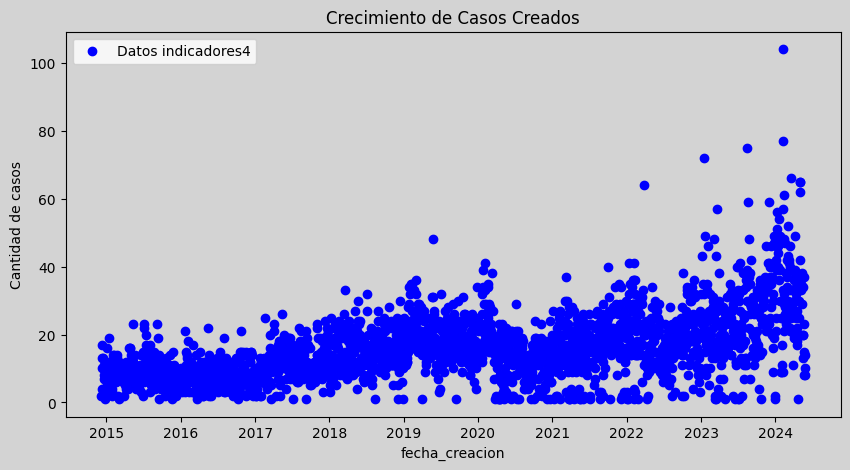

In [570]:
# Visualización de los datos simulados
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
fig.patch.set_facecolor('#d3d3d3') 
ax.set_facecolor('#d3d3d3')  # Establecer fondo gris claro
plt.scatter(indicadores4['fecha_creacion'], indicadores4['cantidadCasos'], color='blue', label='Datos indicadores4')
plt.xlabel('fecha_creacion')
plt.ylabel('Cantidad de casos')
plt.title('Crecimiento de Casos Creados')
plt.legend()
plt.show()


In [571]:
#Se crea un dataframe especifico para almacenar lo corrido del año 2024 para despues comparar 
indicadoresPeriodo2024 = indicadores4[(indicadores4['fecha_creacion']>= '2024-01-01') & (indicadores4['fecha_creacion']<= '2024-12-31')]

C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\1119986232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indicadoresPeriodo['fecha'] = (indicadoresPeriodo['fecha_creacion'] - indicadoresPeriodo['fecha_creacion'].min()).dt.days + 1
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\1119986232.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indicadoresPeriodo2024['fecha'] = (indicadoresPeriodo2024['fecha_creacion'] - indicadoresPeriodo2024['fecha_creacion'].min()).dt.days + 1


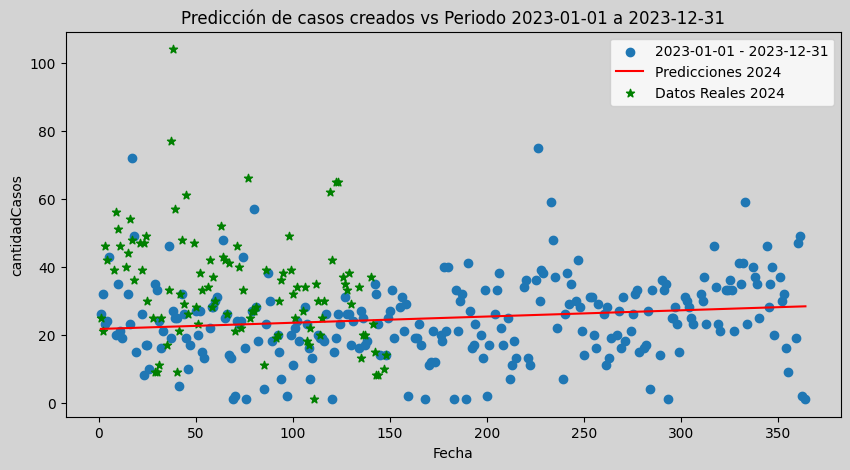

Raíz del Error Cuadrático Medio (RMSE): 10.059207526818144


In [674]:
#Ejecución del modelo de Regresión lineal
#Conversion de date a un numero entero
indicadoresPeriodo['fecha'] = (indicadoresPeriodo['fecha_creacion'] - indicadoresPerodo['fecha_creacion'].min()).dt.days + 1
indicadoresPeriodo2024['fecha'] = (indicadoresPeriodo2024['fecha_creacion'] - indicadoresPeriodo2024['fecha_creacion'].min()).dt.days + 1
#fecha_creacion 	año_creacion 	mes_creacion 	dia_creacion 	diasemana_creacion 	cantidadCasos

#Se separan los datos de variables independientes (X) y dependientes (y)
X = indicadoresPeriodo[['fecha']]  
y = indicadoresPeriodo['cantidadCasos'].values  

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=1000)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Graficar los datos y las predicciones
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
fig.patch.set_facecolor('#d3d3d3') 
ax.set_facecolor('#d3d3d3')  # Establecer fondo gris claro
plt.scatter(indicadoresPeriodo['fecha'], indicadoresPeriodo['cantidadCasos'], label=f'{fecha_inicio.date()} - {fecha_fin.date()}')
plt.plot(indicadoresPeriodo[['fecha']], model.predict(X), color='red', label='Predicciones 2024')
plt.scatter(indicadoresPeriodo2024['fecha'], indicadoresPeriodo2024['cantidadCasos'], color='green', label='Datos Reales 2024', marker='*')
plt.xlabel('Fecha')
plt.ylabel('cantidadCasos')
plt.title(f'Predicción de casos creados vs Periodo {fecha_inicio.date()} a {fecha_fin.date()}')
plt.legend()
plt.show()

# Calcular el error cuadrático medio (RMSE) en el conjunto de prueba
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

In [682]:
indicadores3.shape

(38343, 18)

In [686]:
indicadores3['fecha_creacion'] = pd.to_datetime(indicadores3['fecha_creacion'])
indicadores3['fecha_atencion'] = pd.to_datetime(indicadores3['fecha_atencion'])
indicadores3['fecha_solucion'] = pd.to_datetime(indicadores3['fecha_solucion'])

In [675]:
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

R²: 0.004756774850556922
MSE: 101.1876560675948
RMSE: 10.059207526818144
MAE: 7.696742578019672


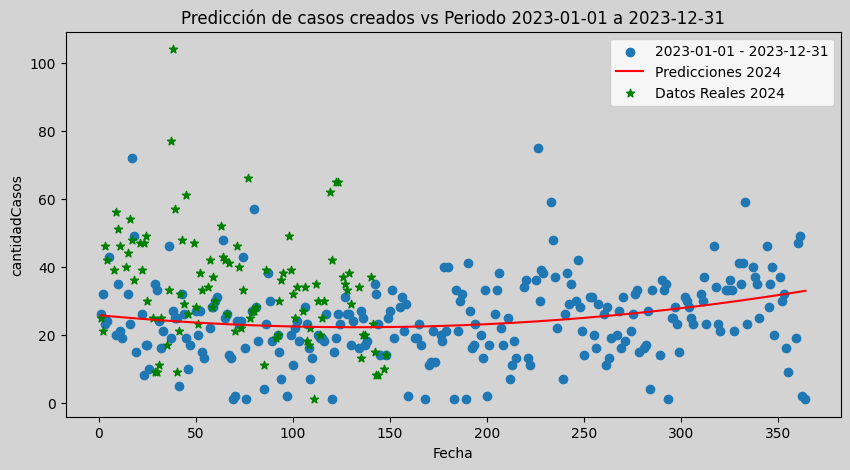

Raíz del Error Cuadrático Medio (RMSE) para regresión polinómica: 9.783468503816952


In [676]:
#Conversion del modelo lineal a modelo polinomial - Se agregan las demás variables independientes 
#fecha_creacion 	año_creacion 	mes_creacion 	dia_creacion 	diasemana_creacion 	cantidadCasos

#Se separan los datos de variables independientes (X) y dependientes (y)
X = indicadoresPeriodo[['fecha']]
#X = indicadoresPeriodo[['fecha']]
y = indicadoresPeriodo['cantidadCasos'].values  

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=1000)

poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

#Se crea el modelo de regresion polinomica
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

#Variable para asignar los valores de prediccion en Y en base a los valores de prueba X
y_poly_pred = poly_model.predict(X_poly_test)

fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
fig.patch.set_facecolor('#d3d3d3') 
ax.set_facecolor('#d3d3d3') 
plt.scatter(indicadoresPeriodo['fecha'], indicadoresPeriodo['cantidadCasos'], label=f'{fecha_inicio.date()} - {fecha_fin.date()}')
plt.plot(indicadoresPeriodo[['fecha']], poly_model.predict(poly.transform(X)), color='red', label='Predicciones 2024')
plt.scatter(indicadoresPeriodo2024['fecha'], indicadoresPeriodo2024['cantidadCasos'], color='green', label='Datos Reales 2024', marker='*')
plt.xlabel('Fecha')
plt.ylabel('cantidadCasos')
plt.title(f'Predicción de casos creados vs Periodo {fecha_inicio.date()} a {fecha_fin.date()}')
plt.legend()
plt.show()
# Calculo de error cuadrateico medio (RMSE) con los valores de preuba
rmse_poly = np.sqrt(mean_squared_error(y_test, y_poly_pred))
print(f'Raíz del Error Cuadrático Medio (RMSE) para regresión polinómica: {rmse_poly}')

In [677]:
r2 = r2_score(y_test, y_poly_pred)
print(f'R²: {r2}')
mse = mean_squared_error(y_test, y_poly_pred)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

mae = mean_absolute_error(y_test, y_poly_pred)
print(f'MAE: {mae}')

R²: 0.05857138125249173
MSE: 95.71625596517832
RMSE: 9.783468503816952
MAE: 7.4853738424472915


In [721]:
indicadoresSoporte = indicadores3[(indicadores3['tipo_de_caso']== 'Incidente') & (indicadores3['proyecto']=='Soporte')]
indicadoresSoporte.shape

(20408, 18)

In [836]:
#Creacion de un nuevo dataframe para elaborar el modelo de Matriz de Confusión
label_encoder = LabelEncoder() 
#Segmentando los datos para evaluar solamente casos solucionados del año 2023
indicadoresMatrix = indicadoresSoporte[(indicadoresSoporte['fecha_solucion']>= '2023-01-01') & (indicadoresSoporte['fecha_solucion']<= '2023-12-31')]
#indicadoresMatrix = indicadoresSoporte.copy()
indicadoresMatrix['fechaCaso'] = label_encoder.fit_transform(indicadoresMatrix['fecha_solucion'])
indicadoresMatrix['CUMPLE_ANS'] = label_encoder.fit_transform(indicadoresMatrix['CUMPLE_ANS'])
indicadoresMatrix['indice'] = indicadoresMatrix.index
indicadoresMX = indicadoresMatrix.copy()

C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\3865823765.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indicadoresMatrix['fechaCaso'] = label_encoder.fit_transform(indicadoresMatrix['fecha_solucion'])
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\3865823765.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indicadoresMatrix['CUMPLE_ANS'] = label_encoder.fit_transform(indicadoresMatrix['CUMPLE_ANS'])
C:\Users\ferodriguez\AppData\Local\Temp\ipykernel_6744\3865823765.py:8: SettingWith

In [837]:
#ELiminar columnas inncesarias
indicadoresMX.drop(columns=['tipo_de_caso','proyecto',
       'username_resp', 'usuariofinal', 'username_ufinal',
       'fecha_solucion', 'fecha_creacion', 'fecha_atencion',
       'diasemana_creacion',
       'mes_creacion', 'dia_creacion', 'año_creacion'], inplace=True)

In [838]:
#Codificacion de columnas con labelencoder para que puedan ser leídas por el modelo
columns_to_encode = ['origen_caso', 'servicio', 
       'responsable']  
# Aplicar LabelEncoder a cada columna en la lista
for column in columns_to_encode:
    indicadoresMX[column] = label_encoder.fit_transform(indicadoresMX[column])
indicadoresMX.dtypes

origen_caso           int32
numero_caso           int64
servicio              int32
responsable           int32
tiempoTranscurrido    int64
CUMPLE_ANS            int32
fechaCaso             int64
indice                int64
dtype: object

In [839]:
indicadoresMX.dtypes

origen_caso           int32
numero_caso           int64
servicio              int32
responsable           int32
tiempoTranscurrido    int64
CUMPLE_ANS            int32
fechaCaso             int64
indice                int64
dtype: object

In [840]:
#CONJUNTOS DE DATOS PARA FECHAS y ENTRENAMIENTO DE MODELO DE REGRESIÓN LOGÍSTICA
#dividimos los datos en caracteristicas X, y en las etiquetas y
X = indicadoresMX.drop(['CUMPLE_ANS','indice','fechaCaso'], axis =1)
y = indicadoresMX['CUMPLE_ANS']
print(X.shape, y.shape)

(4393, 5) (4393,)


In [841]:
#Entrenamiento en el conjunto de datos 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42)
#Creamos el modelo de regresión logística
modelo = LogisticRegression()
#Entrenar el modelo
modelo.fit(X_train, y_train)

#Se realizan predicciones con el conjunto de pruebas
y_pred=modelo.predict(X_test)

#Mostrar la precisión del modelo con accuracy: Predicciones correctas (TP+TN) / el total de predicciones positivas y negativas (TP+TN+FP+FN)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precision del modelo:{accuracy*100: .2f}")

Precision del modelo: 93.52


C:\Users\ferodriguez\AppData\Local\miniconda3\envs\lapby\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [850]:
#Mostrar la matriz de confusión para evaluar el rendimiento del modelo
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusion")
print(conf_matrix)
print(f'total registros para la prueba 20%:',len(y_test))

Matriz de confusion
[[ 14  54]
 [  3 808]]
total registros para la prueba 20%: 879


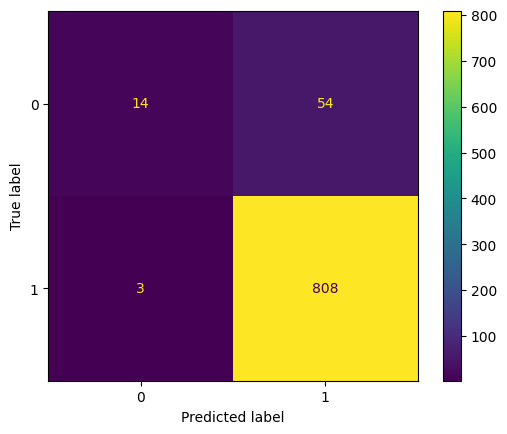

In [843]:
#Generar gráfico de matriz de confusión
GraficoMC = sklearn.metrics.ConfusionMatrixDisplay(conf_matrix)
GraficoMC.plot()

In [852]:
#EVALUACIÓN DEL MODELO CON OTRAS MÉTRICAS
#Utilizando la cruzada para validar el modelo
scores = cross_val_score(modelo, X_train, y_train, cv=5)

# Imprimir los puntajes de la validación cruzada
print("Puntajes de la validación cruzada:", scores)

# Calcular la media y la desviación estándar de los puntajes
print("Media del puntaje de validación cruzada:", np.mean(scores))
print("Desviación estándar del puntaje de validación cruzada:", np.std(scores))

Puntajes de la validación cruzada: [0.93314367 0.91749644 0.92034139 0.92460882 0.93447293]
Media del puntaje de validación cruzada: 0.9260126523284418
Desviación estándar del puntaje de validación cruzada: 0.006768862711951065


C:\Users\ferodriguez\AppData\Local\miniconda3\envs\lapby\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ferodriguez\AppData\Local\miniconda3\envs\lapby\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

In [853]:
#medida de precision (Proporcion de predicciones verdaderas positivas (TP) / total de predicciones positivas TP + FP
print("Métrica de precisión:",sklearn.metrics.precision_score(y_test, y_pred))
#medida de recall o exhaustividad Proporcion de predicciones verdaderas positivas (TP) con respecto al total de observaciones
#positivas (TP + FN)
print("Métrica de Recall:",sklearn.metrics.recall_score(y_test, y_pred))
#Ejemplo con f1 Score -> Es mejor que accuracy para datos desbalanceados
f1 = f1_score(y_test, y_pred)
print("Métrica de F1 Score:", f1)

Métrica de precisión: 0.9373549883990719
Métrica de Recall: 0.9963008631319359
Métrica de F1 Score: 0.9659294680215182
